# Tarea N° 2: Esquemas de aproximación aleatorizados para conteo

En este documento se desarrollará la implementación de un esquema de **aproximación aleatorizado para conteo**, en particular para modelos **Hard-Core** y de **q-Coloraciones**, en solución a la **tarea N° 2** del curso de **Cadenas de Markov y Aplicaciones 2024-1**.

Se iniciará con el código para realizar las simulación de Monte Carlo para Cadenas de Markov (MCMC), que aunque similar al de la tarea 1, se reestructuró para permitir manejar facilmente las aristas del grafo y para permitir el manejo de grafos más allá de latices. Igualmente se separaron las funciones en clases con el objetivo de evitar la repetición de código y operaciones innecesarias cuando no se requiera realizar una animación.

A continuación las librerías usadas en las implentaciones:

In [1]:
# Standard library imports
import re
from abc import ABC, abstractmethod
from collections import defaultdict
import time
import csv
import itertools

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
import sympy as sp
from juliacall import Main as jl
import pandas as pd

# NumPy: Used for general numerical operations and array manipulations
# Matplotlib: Used for creating static, animated, and interactive visualizations
# NetworkX: Used for creating and visualizing the graphs
# Seaborn: Used for creating color palettes for q-colorations
# IPython: Used for displaying interactive content in Jupyter notebooks
# SymPy: Used for symbolic math and solving equations
# JuliaCall: Used for calling Julia functions

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


## Clase "Sampler"

Se separó el esquema general para la simulación de Monte Carlo para cadenas de Markov (MCMC) en la clase Sampler y sus subclases **GibbsSampler** y **SystematicSweepGibbsSampler**. La elección del nuevo estado de acuerdo a la $\pi$-distribución condicional del valor del nodo actual dados los demás nodos, se especifica en cada modelo y es independiente al sampler.

En la subclase **SystematicSweepGibbsSampler** se hace la implementación del Gibbs Sampler con un recorrido sistemático de los nodos (de izquierda a derecha). En el caso del recorrido sistemático, cemos en una configuración factible tras $k$ iteraciones (con $k$ el número de nodos) y también tenemos cotas superiores para el número de iteraciones necesarias para acercarnos a la distribución estacionaria $\pi$ a una distancia $\epsilon$. En [1] vemos que la cota está dada por el siguiente teorema:

**Teorema 1:**  
Sea $ G = (V, E) $ un grafo. Sea $ k $ el número de vértices en $ G $, y supongamos que cualquier vértice $ v \in V $ tiene a lo sumo $ d $ vecinos. Supongamos además que $ q > 2d^2 $. Entonces, para cualquier $ \epsilon > 0 $, el número de iteraciones necesarias para que el **Systematic Sweep Gibbs Sampler** llegue a una distancia de variación total $ \epsilon $ de la distribución objetivo $ \pi $ es a lo sumo:

$$
k \left( \frac{\log(k) + \log(\epsilon^{-1}) - \log(d)}{\log\left(\frac{q}{2d^2}\right)} + 1 \right).
$$

Sin embargo, vemos que si tomamos $d =4$, debemos tener mínimo $q = 33$. Con lo cuálveamos a [2], que nos presenta la siguiente cota:

**Teorema 2:**
Sea $ G $ un grafo con grado máximo $ d $ y $ k $ vértices. Suponiendo que $ q \geq 2d + 1 $, el tiempo de convergencia $ \tau(\epsilon) $ de la cadena de Markov $ M(G, q) $ está acotado superiormente por:

$$
\tau_{x}(\epsilon) \leq \frac{q}{q - 2d} \cdot k \ln\left(\frac{k}{\epsilon}\right),
$$

independientemente del estado inicial $ X $.

El **Teorema 2** nos lleva a tener ahora cotas para $q>9$ con $d=4$. (tomamos $d=4$ pues es el valor de nuestro interés.) 

Sin embargo aún no tenemos información para valores de $q$ menores a $2d$ (o menores a $2d^2$). Para tener un valor estimado que de solución a este problema, en lso casos en los que las restricciones no se cumplan, se elige $q$ tal que cumpla la restricción (Por ejemplo si tenemos $q=3$ y $ d=4 $, se ajusta $q=33$ para [1] o $q=9$ para [2]) y se calcula la cota correspondiente al nuevo valor de $q$ y finalmente se ajusta el valor dividiendo por una potencia de $q$ que debe ser ajustada de forma completamente experimental al comparar (Por lo menos con las q-Coloraciones) con los modelos exactos. De esta forma fue implementado el cálculo de las iteraciones necesarias para tener un correcto muestreo.

[1] Häggström, O. (2002). *Finite Markov chains and algorithmic applications*. [Reference](https://doi.org/10.1017/cbo9780511613586)

[2] Jerrum, M. (1995). *Estimating the number of k-colorings in low-degree graphs*. [Reference](https://doi.org/10.1002/rsa.3240070205)



Como se acabó de mencionar, al usar estas cotas tal cual como las enuncian en los textos ya citados, vemos que las restricciones nos generan problemas pues vamos a necesitar utilizar valores de q menores a los permitidos. Veamos como se ven las cotas para todo q:

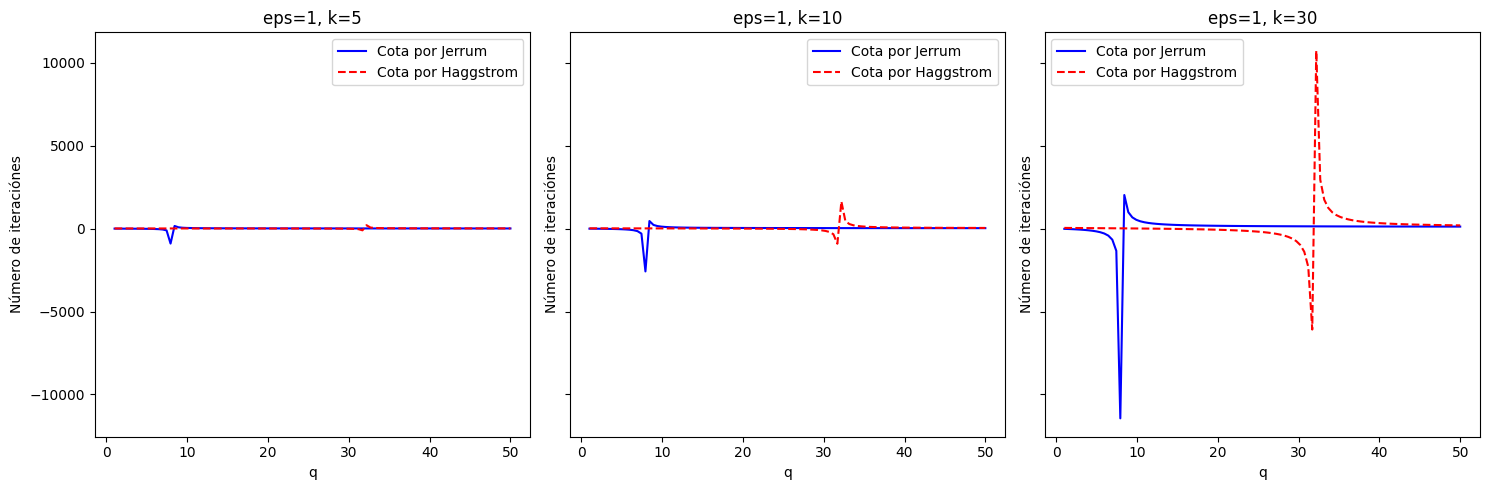

In [2]:

def calculate_jerrum_bound(d, q, k, eps):
    return ((q / (q - 2*d)) * k * np.log(k / eps))

def calculate_haggstrom_bound(d, q, k, eps):
    return (k * ((np.log(k) + np.log(1/eps) - np.log(d)) / np.log(q / (2 * d**2)) + 1) + k)

d = 4
q_values = np.linspace(1, 50, 100) 
eps_values = [1] 
k_values = [5, 10, 30]  

fig, axes = plt.subplots(len(eps_values), len(k_values), figsize=(15, 5), sharex=True, sharey=True)
axes = axes.flatten()

for i, eps in enumerate(eps_values):
    for j, k in enumerate(k_values):
        q_vals = q_values
        jerrum_vals = [calculate_jerrum_bound(d, q, k, eps) for q in q_vals]
        haggstrom_vals = [calculate_haggstrom_bound(d, q, k, eps) for q in q_vals]
        
        ax = axes[i * len(k_values) + j]
        ax.plot(q_vals, jerrum_vals, label='Cota por Jerrum', color='blue', linestyle='-')
        ax.plot(q_vals, haggstrom_vals, label='Cota por Haggstrom', color='red', linestyle='--')
        ax.set_title(f'eps={eps}, k={k}')
        ax.set_xlabel('q')
        ax.set_ylabel('Número de iteraciónes')
        ax.legend()

plt.tight_layout()
plt.show()


Y ahora, con el ajuste que se ha descrito, veamos como se ven las cotas que se usarán:

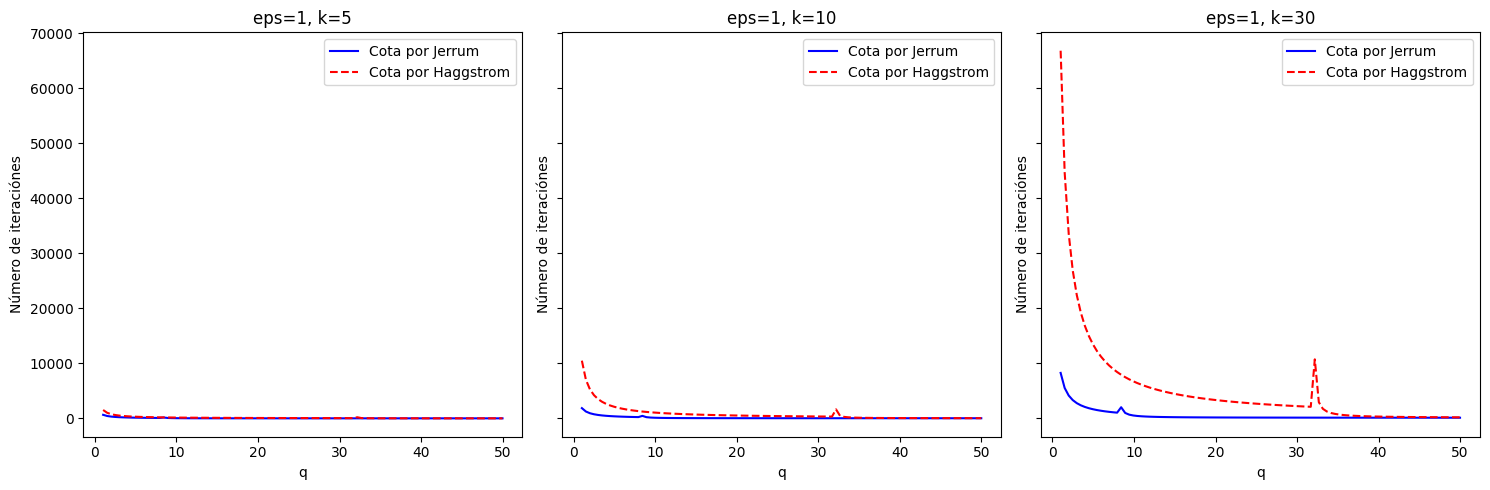

In [3]:
def adjust_q(d, q, bound):
        if bound == "jerrum":
            if q <= 2 * d:
                q_min = 2 * d + 1
                adjustment_factor = q_min / q ** (1/1)
                return q_min, adjustment_factor
        elif bound == "haggstrom":
            if q <= 2 * d**2:
                q_min = 2 * d**2 + 1
                adjustment_factor = q_min / q ** (1/1)
                return q_min, adjustment_factor
        return q, 1


def calculate_jerrum_bound(d, q, k, eps):
    q, adjustment_factor = adjust_q(d, q,"jerrum")
    return ((q / (q - 2*d)) * k * np.log(k / eps))*adjustment_factor

def calculate_haggstrom_bound(d, q, k, eps):
    q, adjustment_factor = adjust_q(d, q, "haggstrom")
    return (k * ((np.log(k) + np.log(1/eps) - np.log(d)) / np.log(q / (2 * d**2)) + 1) + k)*adjustment_factor

d = 4
q_values = np.linspace(1, 50, 100) 
eps_values = [1]  
k_values = [5, 10, 30]  

fig, axes = plt.subplots(len(eps_values), len(k_values), figsize=(15, 5), sharex=True, sharey=True)

axes = axes.flatten()

for i, eps in enumerate(eps_values):
    for j, k in enumerate(k_values):
        q_vals = q_values
        jerrum_vals = [calculate_jerrum_bound(d, q, k, eps) for q in q_vals]
        haggstrom_vals = [calculate_haggstrom_bound(d, q, k, eps) for q in q_vals]
        
        ax = axes[i * len(k_values) + j]
        ax.plot(q_vals, jerrum_vals, label='Cota por Jerrum', color='blue', linestyle='-')
        ax.plot(q_vals, haggstrom_vals, label='Cota por Haggstrom', color='red', linestyle='--')
        ax.set_title(f'eps={eps}, k={k}')
        ax.set_xlabel('q')
        ax.set_ylabel('Número de iteraciónes')
        ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


Las cotas cambiarán ligeramente en el contexto del esquema de aproximación aleatorizado, pero se usarán la misma forma de ajustar el valor de la cota (número de iteraciones) para valores de fuera de la restricción.

In [4]:
class Sampler(ABC):
    """
    Abstract base class for sampling algorithms.

    This class defines the basic structure for sampling algorithms used in graph models.
    """
    def __init__(self, graph_model, simulation_config = None, animation_config = None):
        """
        Initialize the Sampler.

        Args:
            graph_model: The graph model to sample from.
            simulation_config: Configuration for the simulation.
            animation_config: Configuration for the animation.
        """
        if simulation_config is None:
            self.simulation_config = SimulationConfig()
            self.max_iterations = 1e4
        else:
            self.simulation_config = simulation_config
            self.max_iterations = simulation_config.steps
        
        self.iteration = 0
        self.graph_model = graph_model
        
        self.animation_config = animation_config
       

    @abstractmethod
    def select_node(self):
        """
        Select a node for updating.

        This method should be implemented by subclasses.

        Returns:
            The selected node.
        """
        pass

    def update_state(self):
        """
        Update the state of the graph model.

        This method increments the iteration count, selects a node, and updates its state
        based on the conditional distribution of the graph model.
        """
        self.increment_iteration()
        if self.iteration > 0:
            self.graph_model.visualizer.set_iteration(self.iteration)
            node = self.select_node()
            new_state = self.graph_model.conditional_distribution(node)
            #TODO: Add option to see when it doesn't fall into a feasible distribution
            if not np.isnan(new_state):
                self.graph_model.graph.set_state(node, new_state)
        
    def increment_iteration(self):
        """Increment the iteration count."""
        self.iteration += 1

    def get_iteration(self):
        """
        Get the current iteration count.

        Returns:
            The current iteration count.
        """
        return self.iteration

    def reset_iterations(self):
        """Reset the iteration count to zero."""
        self.iteration = 0

    def simulate(self):
        """
        Run the simulation.

        If animation is enabled in the simulation config, it returns an animation.
        Otherwise, it runs the simulation for the specified number of iterations.

        If the sampling method is Systematic Sweep Gibbs Sampler then the number 
        of iterations can be atomatically calculated.

        Returns:
            An animation if animation is enabled, None otherwise.
        """
        if self.simulation_config.animation:
            self.iteration = -2
            return self.graph_model.visualizer.animate(self.update_state, self.simulation_config, self.animation_config)
        else:
            for _ in range(self.max_iterations):
                self.update_state()
        
class GibbsSampler(Sampler):
    """
    Implementation of the Gibbs sampling algorithm.
    """
    def __init__(self, graph_model, simulation_config = None, animation_config=None):
        """
        Initialize the Gibbs Sampler.

        Args:
            graph_model: The graph model to sample from.
            simulation_config: Configuration for the simulation.
            animation_config: Configuration for the animation.

        Raises:
            ValueError: If steps are not defined in the simulation config.
        """
        if simulation_config is not None and simulation_config.steps is None:
            raise ValueError("Steps must be define in Random Gibbs Sampler")
        super().__init__(graph_model, simulation_config, animation_config)
    
    def select_node(self):
        """
        Randomly select a node for updating.

        Returns:
            The randomly selected node.
        """
        selected_node = np.random.randint(self.graph_model.graph.num_nodes)
        if self.simulation_config.animation:
            self.animation_config.selected_node = selected_node
        return self.animation_config.selected_node


class SystematicSweepGibbsSampler(Sampler):
    """
    Implementation of the Systematic Sweep Gibbs sampling algorithm.
    """
    def __init__(self, graph_model, simulation_config = None, animation_config = None, eps = None, bound = "jerrum", show_iterations = True):
        """
        Initialize the Systematic Sweep Gibbs Sampler.

        Args:
            graph_model: The graph model to sample from.
            simulation_config: Configuration settings for the simulation.
            animation_config: Configuration settings for animation.
            eps: Epsilon value for bound calculations.
            bound: Type of bound to use. Options are:
                - "jerrum": Bound from Jerrum, M. (1995) for estimating the number of k-colorings in low-degree graphs. 
                [Reference](https://doi.org/10.1002/rsa.3240070205)
                - "haggstrom": Bound from Häggström, O. (2002) for finite Markov chains and algorithmic applications.
                [Reference](https://doi.org/10.1017/cbo9780511613586)

                For values ​​not covered by the above bounds, take the q valid for 
                the bound according to the given d and adjust the iteration value 
                by dividing by a power of q (At this moment it is 1).
                The power value is designated in a completely experimental way.
        """
        super().__init__(graph_model, simulation_config , animation_config)
        self.selected_node = 0
        d = self.graph_model.graph.d
        if eps is not  None:
            #TODO: Error handling and verifying feasible initial state
            k = self.graph_model.graph.num_nodes
            q, adjustment_factor = self.adjust_q(d, self.graph_model.q, bound)

            if bound.lower() == "jerrum":
                self.max_iterations = int(((q / (q - 2*d)) * k * np.log(k / eps))*adjustment_factor)
            elif bound.lower() == "haggstrom":
                self.max_iterations = int((k * ((np.log(k) + np.log(1/eps) - np.log(d)) / np.log(q / (2 * d**2)) + 1) + k)*adjustment_factor)
            
            self.simulation_config.steps = self.max_iterations
            if show_iterations:
                print("Iterations: ", self.max_iterations)
    
    def adjust_q(self,d, q, bound):
        """
        Adjust the q value based on the chosen bound.

        Args:
            d: d value for bound calculation (maximum neighbor degree).
            q: Initial q value.
            bound: The type of bound to use ("jerrum" or "haggstrom").

        Returns:
            A tuple containing the adjusted q value and the adjustment factor.
        """
        if bound == "jerrum":
            if q <= 2 * d:
                q_min = 2 * d + 1
                adjustment_factor = q_min / q
                return q_min, adjustment_factor
        elif bound == "haggstrom":
            if q <= 2 * d**2:
                q_min = 2 * d**2 + 1
                adjustment_factor = q_min / q
                return q_min, adjustment_factor
        return q, 1

    def select_node(self):
        """
        Select the next node in a systematic sweep.

        Returns:
            The selected node.
        """
        self.selected_node = (self.selected_node)%self.graph_model.graph.num_nodes
        if self.simulation_config.animation:
            self.animation_config.selected_node = self.selected_node
        node = self.selected_node
        self.selected_node +=1
        return node

## Clase "Config"

Con Config y sus subclases **simulation_config** y **animation_config**, se definen las configuraciones de simulación y animación, ayudando a facilitar el uso del código.

In [5]:
class Config(ABC):
    """
    Abstract base class for configuration objects.
    """
    @abstractmethod
    def validate(self):
        """
        Validate the configuration.

        Raises:
            ?????Error.
        """
        # TODO: Select error type.
        pass

class SimulationConfig(Config):
    """
    Configuration class for simulation parameters.
    """
    def __init__(self, steps = None, animation=False):
        """
        Initialize the SimulationConfig.

        Args:
            steps (int, optional): Number of simulation steps. Defaults to None.
            animation (bool, optional): Whether to create an animation. Defaults to False.
        """
        self.steps = steps
        self.animation = animation

    def validate(self):
        """
        Validate the simulation configuration.

        Raises:
            ValueError: If the number of steps is not positive.
        """
        if self.steps <= 0:
            raise ValueError("Steps must be positive")

class AnimationConfig(Config):
    """
    Configuration class for animation parameters.
    """
    def __init__(self, filename=None, node_labels=False, labels = None, title=None, interval=100, writer=PillowWriter(fps=10), blit=False, repeat=False, highlight_selected_node=True, custom_node_size = None, custom_figure_size = None):
        """
        Initialize the AnimationConfig.

        Args:
            filename (str, optional): Output filename for the animation. Defaults to None.
            node_labels (bool, optional): Whether to show node labels. Defaults to False.
            labels (str, optional): Defines the type of information for the labels. Defaults to None.
            title (str, optional): Title of the animation. Defaults to None.
            interval (int, optional): Interval between frames in milliseconds. Defaults to 100.
            writer (matplotlib.animation.Writer, optional): Animation writer. Defaults to PillowWriter(fps=10).
            blit (bool, optional): Whether to use blitting. Defaults to False.
            repeat (bool, optional): Whether to repeat the animation. Defaults to False.
            highlight_selected_node (bool, optional): Whether to highlight the selected node. Defaults to True.
            custom_node_size (int, optional): Custom size for nodes. Defaults to None.
            custom_figure_size (tuple, optional): Custom figure size. Defaults to None.
        """
        self.filename = filename
        self.node_labels = node_labels
        self.labels = labels
        self.title = title
        self.interval = interval
        self.writer = writer
        self.blit = blit
        self.repeat = repeat
        self.highlight_selected_node = highlight_selected_node
        self.selected_node = None
        self.custom_node_size = custom_node_size
        self.custom_figure_size = custom_figure_size
        self.ax = None  # This will be set when creating the animation

    def validate(self):
        """
        Validate the animation configuration.

        Raises:
            ValueError: If the interval is not positive.
        """
        if self.interval <= 0:
            raise ValueError("Interval must be positive")

## Clase "Graph"

Se implemento una clase "Graph" con la intención de no limitarse a usar latices. La representación del grafo que cambiada de una matriz cuyos valores representaban cada nodo, a una lista de adyacencia.

In [6]:
import numpy as np
from collections import defaultdict

class Graph:
    """
    Represents a graph with nodes and edges.

    Attributes:
        num_nodes (int): Number of nodes in the graph.
        num_states (int): Number of distinct states for the nodes.
        adjacency_list (defaultdict of set): Adjacency list where each key is a node and each value is a set of neighboring nodes.
        node_states (numpy.ndarray): Array of node states, initialized with np.nan.
        state_counts (numpy.ndarray): Counts of each state.
        states (numpy.ndarray): Array of possible states.
        edges (list): List of tuples representing edges (i, j) where i and j are connected nodes.
        d (int): Maximum degree of the graph.
    """
    def __init__(self, num_nodes = 0):
        """
        Initialize the Graph with a given number of nodes.

        Args:
            num_nodes (int, optional): The number of nodes in the graph. Defaults to 0.
        """
        self.num_nodes = num_nodes
        self.num_states = 0
        self.adjacency_list = defaultdict(set)
        self.node_states = np.full(num_nodes, np.nan)  # Initialize with np.nan
        self.state_counts = None
        self.states = None
        self.edges = []
        self.d = 0
        
    def initialize_states(self, states):
        """
        Initialize the states of the graph nodes.

        Args:
            states (numpy.ndarray): Array of possible states for the nodes.
        """
        self.states = states
        self.num_states = len(states)
        self.state_counts = np.zeros(self.num_states, dtype=int)

    def add_edge(self, node1, node2):
        """
        Add an edge between two nodes in the graph.

        Args:
            node1 (int): The first node.
            node2 (int): The second node.
        """
        self.adjacency_list[node1].add(node2)
        self.adjacency_list[node2].add(node1)
        self.edges.append((min(node1, node2), max(node1, node2)))
        self._update_max_degree(node1)
        self._update_max_degree(node2)

    def _update_max_degree(self, node):
        """
        Update the maximum degree of the graph.

        Args:
            node (int): The node whose degree has changed.
        """
        node_degree = len(self.adjacency_list[node])
        if node_degree > self.d:
            self.d = node_degree

    def get_neighbors(self, node):
        """
        Get the neighbors of a given node.

        Args:
            node (int): The node whose neighbors are to be retrieved.

        Returns:
            list: A list of neighbors for the specified node.
        """
        return list(self.adjacency_list[node])

    def get_state(self, node):
        """
        Get the state of a given node.

        Args:
            node (int): The node whose state is to be retrieved.

        Returns:
            int or np.nan: The state of the specified node.
        """
        return self.node_states[node]

    def set_state(self, node, state):
        """
        Set the state of a given node.

        Args:
            node (int): The node whose state is to be set.
            state (int): The new state to be assigned to the node.
        """
        old_state = self.get_state(node)
        if not np.isnan(old_state):
            self.state_counts[int(old_state)] -= 1
        self.state_counts[state] += 1
        self.node_states[node] = state
        
    def add_node(self):
        """
        Add a new node to the graph and update its adjacency list.
        """
        new_node = self.num_nodes
        self.num_nodes += 1
        new_node_states = np.full(self.num_nodes, np.nan)
        new_node_states[:-1] = self.node_states
        self.node_states = new_node_states
        self.adjacency_list[new_node] = set()

    @classmethod
    def create_lattice(cls, size):
        """
        Create a lattice graph with the given size.

        Args:
            size (int): The size of the lattice (number of rows/columns).
            
        Returns:
            Graph: The created lattice graph.
        """
        graph = cls(size * size)
        if size == 1:
            graph.adjacency_list[0] = set()
            return graph
        
        for i in range(size):
            for j in range(size):
                node = i * size + j
                if i > 0:
                    graph.add_edge(node, node - size)
                if j > 0:
                    graph.add_edge(node, node - 1)
        return graph
            
    def get_disconnected_graph(self):
        """
        Returns a new Graph object with the same number of nodes and states,
        but with all nodes disconnected (empty adjacency list).
    
        Returns:
            Graph: A new Graph object with disconnected nodes.
        """
        
        disconnected_graph = Graph(self.num_nodes)
    
        disconnected_graph.num_states = self.num_states
        disconnected_graph.states = self.states.copy() if self.states is not None else None
        disconnected_graph.node_states = self.node_states.copy()
        disconnected_graph.state_counts = self.state_counts.copy() if self.state_counts is not None else None
    
        for node in range(self.num_nodes):
            disconnected_graph.adjacency_list[node] = set()
    
        return disconnected_graph
            
    def display_info(self):
        """
        Print information about the graph, including node states, state counts, adjacency list, edges, and maximum degree.
        """
        print("===================================================")
        print("Graph Information:")
        print(f"Number of Nodes: {self.num_nodes}")
        print(f"Number of States: {self.num_states}")
        print(f"Maximum Degree: {self.d}")
        
        print("\nNode States:")
        for node in range(self.num_nodes):
            print(f"Node {node}: State {self.node_states[node]}")
        
        print("\nState Counts:")
        for state in range(self.num_states):
            print(f"State {state}: Count {self.state_counts[state]}")
        
        print("\nAdjacency List:")
        for node, neighbors in self.adjacency_list.items():
            print(f"Node {node}: Neighbors {list(neighbors)}")
        
        print("\nEdges:")
        print(self.edges)
        print("===================================================")

## Class "GraphVisualizer"

Se separo por completo las funciones de visualización de la clase Graph en la clase GraphVisualizer. Se encarga de dibujar el grafo y animar el proceso de muestreo, así como todas las opciones de visualización que fueron requeridas.

In [7]:
class GraphVisualizer:
    """
    Visualizes a graph with customizable options.

    Attributes:
        graph (Graph): The graph to visualize.
        pos (dict, optional): Position layout for nodes in the visualization.
        edges_enable (bool): Whether to display edges lines of the nodes.
        selected_node (int, optional): The node currently selected for highlighting.
        highlight_selected_node (bool): Whether to highlight the selected node.
        iteration (int): The current iteration count for animation titles.
    """
    def __init__(self, graph, edges_enable=True):
        """
        Initialize the GraphVisualizer.

        Args:
            graph (Graph): The graph to be visualized.
            edges_enable (bool, optional): Whether to display edges lines of the nodes. Defaults to True.
        """
        self.graph = graph
        self.pos = None
        self.edges_enable = edges_enable
        self.selected_node = None
        self.highlight_selected_node = True
        self.iteration = 0

    def set_selected_node(self, node):
        """
        Set the node to be highlighted.

        Args:
            node (int): The node to be highlighted.
        """
        self.selected_node = node
        
    def set_iteration(self, iteration):
        """
        Set the current iteration count for animation titles.

        Args:
            iteration (int): The current iteration count.
        """
        self.iteration = iteration

    def set_highlight_selected_node(self, highlight):
        """
        Set whether the selected node should be highlighted.

        Args:
            highlight (bool): Whether to highlight the selected node.
        """
        self.highlight_selected_node = highlight

    def draw(self, ax, node_labels=False, labels = None, title=None, custom_node_size=None):
        """
        Draw the graph on the given axes.

        Args:
            ax (matplotlib.axes.Axes): The axes on which to draw the graph.
            node_labels (bool, optional): Whether to display node labels. Defaults to False.
            labels (str, optional): The type of labels to display ('states', 'node', or None). Defaults to None.
            title (str, optional): The title of the plot. Defaults to None.
            custom_node_size (int, optional): Custom size for nodes. Defaults to None.
        """
        ax.clear()
        G = nx.Graph(dict(sorted(self.graph.adjacency_list.items())))
        if self.pos is None:
            self.pos = self._generate_grid_layout(G)

        colors = [self.graph.states[state] for state in self.graph.node_states]

        if custom_node_size is None:
            node_sizes = [self._calculate_node_size(self.graph.num_nodes)] * self.graph.num_nodes
        else:
            node_sizes = [custom_node_size] * self.graph.num_nodes

        if self.highlight_selected_node and self.selected_node is not None:
            node_sizes[self.selected_node] *= 1.5 

        if labels == "states":
            labels_list = {i: str(self.graph.node_states[i]) for i in range(self.graph.num_nodes)}
        elif labels == "node":
            labels_list = {i: str(i) for i in range(self.graph.num_nodes)}
        else:
            labels_list = None

        if self.edges_enable:
            nx.draw(G, self.pos, node_color=colors, with_labels=node_labels, labels=labels_list, ax=ax, edgecolors='black', node_size=node_sizes)
        else:
            nx.draw(G, self.pos, node_color=colors, with_labels=node_labels, labels=labels_list, ax=ax, node_size=node_sizes)

        if title:
            ax.set_title(self._format_title(title))

    def _calculate_node_size(self, n):
        """
        Calculate the node size based on the number of nodes.

        Args:
            n (int): The number of nodes.

        Returns:
            float: The calculated node size.
        """
        #TODO: Create a generalized formula for node size

        if n == 1:
            size = 9e3 / n
        elif n == 2:
            size = 1e4 / n
        elif n == 3:
            size = 2e4 / n
        elif n == 4:
            size = 3e4 / n
        elif n == 9:
            size = 8e4 / n
        elif n == 16:
            size = 1e5 / n
        else:
            size = 2e5 / n
        return size

    def animate(self, update_frame_function, simulation_config, animation_config):
        """
        Create an animation of the graph visualization.

        Args:
            update_frame_function (callable): Function to update the graph for each frame.
            simulation_config (SimulationConfig): Configuration for the simulation.
            animation_config (AnimationConfig): Configuration for the animation.

        Returns:
            HTML or bool: Returns an HTML animation if no filename is provided; otherwise, returns True if saved successfully.
        """
        fig_kwargs = {}
        if animation_config.custom_figure_size is not None:
            fig_kwargs['figsize'] = animation_config.custom_figure_size
        
        fig, ax = plt.subplots(**fig_kwargs)
        animation_config.ax = ax
        self.set_highlight_selected_node(animation_config.highlight_selected_node)

        def update(frame):
            ax.clear()
            update_frame_function()
            self.set_selected_node(animation_config.selected_node)
            self.draw(ax, node_labels=True, labels = animation_config.labels,
             title=animation_config.title, custom_node_size = animation_config.custom_node_size)

        anim = FuncAnimation(fig, update, frames=simulation_config.steps + 1,
                             interval=animation_config.interval, blit=animation_config.blit,
                             repeat=animation_config.repeat)

        if animation_config.filename:
            anim.save(animation_config.filename, writer=animation_config.writer)
            plt.close(fig)
            return True
        else:
            html = HTML(anim.to_jshtml())
            plt.close(fig)
            return html

    def _generate_grid_layout(self, G):
        """
        Generate a grid (lattice) layout for node positions.

        Args:
            G (networkx.Graph): The graph to layout.

        Returns:
            dict: A dictionary mapping nodes to their (x, y) positions.
        """
        side_len = int(len(G.nodes()) ** 0.5)
        pos = {}
        for node in G.nodes():
            row = node // side_len
            col = node % side_len
            pos[node] = (col, -row)
        return pos

    def _format_title(self, title):
        """
        Format the title string with dynamic values.

        Args:
            title (str): The title string containing placeholders.

        Returns:
            str: The formatted title string.
        """
        title = re.sub(r'&iteration&', str(self.iteration), title)
        title = re.sub(r'&selected_node&', str(self.selected_node), title)
        title = re.sub(r'&num_nodes&', str(self.graph.num_nodes), title)
        title = re.sub(r'&lattice_size&', str(int(self.graph.num_nodes ** 0.5)), title)
        title = re.sub(r'&num_states&', str(self.graph.num_states), title)
        #TODO: Add count from a single state
        return title

## Clase "GraphModel"

La clase **GraphModel** generaliza los modelos que se usarán, define los métodos necesarios y en las subclases **QColoration** y **Hardcore** se implementan los métodos correspondientes, incluyendo la elección del nuevo estado a partir de una distribución condicional especifica para el problema.

In [8]:
class GraphModel(ABC):
    """
    Abstract base class for graph models.

    Attributes:
        graph (Graph): The graph associated with the model.
        visualizer (GraphVisualizer): Visualizer for the graph.
    """

    def __init__(self, graph = None):
        """
        Initialize the GraphModel.

        Args:
            graph (Graph, optional): The graph to be used by the model. Defaults to None.
        """
        self.graph = graph
        self.visualizer = GraphVisualizer(self.graph)

    @abstractmethod
    def is_feasible(self):
        """
        Determine if the current state of the model is feasible.

        Returns:
            bool: True if the model's state is feasible, otherwise False.
        """
        pass
        
    @abstractmethod
    def conditional_distribution(self, node):
        """
        Compute the conditional distribution for a given node with respect to the current state.

        Args:
            node (int): The node for which the conditional distribution is computed.

        Returns:
            int or np.nan: The new state for the node, or np.nan if no valid state is available.
        """
        pass
    
    def get_configuration_counter(self):
        """
        Get the configuration counter for the model.
        Returns:
            ConfigurationCounter: The counter that returns the number of feasibles configurations.
        """
        return FeasibleConfigurationCounter(self)

    def get_disconnected_model(self):
        """
        Returns a new instance of the GraphModel with a disconnected graph.
        All other properties remain the same.
    
        Returns:
            GraphModel: A new instance of the model with a disconnected graph.
        """
        disconnected_model = self.__class__(graph = self.graph.get_disconnected_graph())
        
        for attr, value in self.__dict__.items():
            if attr != 'graph' and attr != 'visualizer':
                setattr(disconnected_model, attr, value)
        
        disconnected_model.visualizer = GraphVisualizer(disconnected_model.graph)
    
        return disconnected_model


class QColoration(GraphModel):
    """
    A graph coloring model where each node can be colored with one of q colors.

    Attributes:
        q (int): The number of colors available.
        colors (dict): Mapping of color indices to color values.
    """
    def __init__(self, graph = None, q = 3, config_type="alternating", size = None):
        """
        Initialize the QColoration model.

        Args:
            graph (Graph, optional): The graph to be used. If None, a lattice graph is created. Defaults to None.
            q (int): The number of colors to use. Must be a positive integer. Defaults to 3.
            config_type (str, optional): The initial configuration of the graph. Can be 'random' or 'alternating'. Defaults to 'random'.
            size (int, optional): Size of the lattice if no graph is provided. Defaults to None.

        Raises:
            TypeError: If q is not an integer.
            ValueError: If q is not positive or if size is None when graph is also None.
        """
        
        if not isinstance(q, int):
            raise TypeError("The parameter 'q' must be an integer.")
        
        if q <= 0:
            raise ValueError("The parameter 'q' must be a positive integer.")
        
        self.q = q
        
        if graph is None:
            if size is None:
                raise ValueError("Parameter 'size' must be defined when 'graph' is None.")
            else:
                super().__init__(Graph.create_lattice(size=size))
        else:
            super().__init__(graph)
            
        self.visualizer = GraphVisualizer(self.graph, edges_enable=False)
        self.colors = self._assign_colors(q)
        self.graph.initialize_states(self.colors)
        self._initialize_graph(config_type)

    def _assign_colors(self, q):
        """
        Assign a distinct color to each state using a color palette.

        Args:
            q (int): The number of colors to assign.

        Returns:
            dict: A mapping of state indices to color values.
        """
        palette = sns.color_palette("husl", q)  # 'husl' es un ejemplo de paleta, hay otras como 'husl', 'cubehelix'
        return {i: palette[i % len(palette)] for i in range(q)}
  

    def _initialize_graph(self, config_type):
        """
        Initialize the graph with a specific configuration.

        Args:
            config_type (str): The type of configuration to use ('random' or 'alternating').

        Raises:
            ValueError: If an invalid configuration type is provided.
        """
        if config_type == "random":
            self.graph.node_states = np.random.choice(range(self.q), size=self.graph.num_nodes)
        elif config_type == "alternating":
            self.graph.node_states[0::2] = 1
            self.graph.node_states[1::2] = 0
        else:
            raise ValueError("Invalid graph configuration type")
        
        # Initialize state_counts
        for i in range(self.q):
            self.graph.state_counts[i] = np.sum(self.graph.node_states == i)

    def is_feasible(self):
        """
        Check if the current coloring is feasible.

        Returns:
            bool: True if the model's state is feasible, otherwise False
        """
        return True
        
    def conditional_distribution(self, node):
        """
        Determine the conditional distribution of the state for a given node. For a node, the 
        possible states are which color is not equal to the color of the neighbors.

        Args:
            node (int): The node for which to determine the state.

        Returns:
            int or np.nan: A new state for the node, or np.nan if no valid state is available.
        """
        neighbors = self.graph.get_neighbors(node)
        banned_colors = set(self.graph.get_state(neighbor) for neighbor in neighbors)
        available_colors = np.setdiff1d(np.arange(self.q), list(banned_colors))
        if available_colors.size > 0:
            new_state = np.random.choice(available_colors)
            return new_state
        else:
            return np.nan

    def get_chromatic_polynomial(self, backend = "julia"):
        if backend == "julia":
            jl.seval("using SimpleGraphs, SimpleGraphAlgorithms")
            jl.seval(f"G = IntGraph({self.graph.num_nodes})")
            for edge in self.graph.edges:
                jl.seval(f"add!(G,{edge[0]+1},{edge[1]+1})")
            print("Calculating chromatic polynomial...")
            return jl.seval("chromatic_poly(G)")
            
        elif backend == "python-nx":
            G = nx.Graph(dict(sorted(self.graph.adjacency_list.items())))
            print("Calculating chromatic polynomial...")
            return nx.chromatic_polynomial(G)

    def get_qcoloration_counting(self, backend = "julia"):
        if backend == "julia":
            return int(self.get_chromatic_polynomial(backend = backend)(self.q))
            
        elif backend == "python-nx":
            x = sp.symbols('x')
            return int(self.get_chromatic_polynomial(backend = backend).subs(x, self.q).evalf())
    def get_disconnected_model(self):
        """
        Returns a new instance of the GraphModel with a disconnected graph.
        All other properties remain the same.
    
        Returns:
            GraphModel: A new instance of the model with a disconnected graph.
        """
        disconnected_model = super().get_disconnected_model()
        
        disconnected_model.graph.initialize_states(disconnected_model.colors)
        disconnected_model._initialize_graph(config_type = "alternating")
                
        return disconnected_model
        
class Hardcore(GraphModel):
    """
    A hardcore model where nodes are colored either black or white.

    This model was introduced in statistical physics to capture some of the behavior of 
    a gas whose particles have nonnegligible radii and cannot overlap; here 1's represent 
    particles and 0's represent empty locations. 
    """
    def __init__(self, graph = None, config_type="empty", size = None):
        """
        Initialize the Hardcore model.

        Args:
            graph (Graph, optional): The graph to be used. If None, a lattice graph is created. Defaults to None.
            config_type (str, optional): The initial configuration of the graph. Can be 'empty', 'random', or 'full'. Defaults to 'random'.
            size (int, optional): Size of the lattice if no graph is provided. Defaults to None.

        Raises:
            ValueError: If size is None when graph is also None, or if an invalid configuration type is provided.
        """
        self.q = 2
        if graph is None:
            if size is None:
                raise ValueError("Parameter 'size' must be defined when 'graph' is None.")
            else:
                super().__init__(Graph.create_lattice(size=size))
        else:
            super().__init__(graph)
            
        self.graph.initialize_states(["white", "black"])
        self._initialize_graph(config_type)

    def _initialize_graph(self, config_type):
        """
        Initialize the graph with a specific configuration.

        Args:
            config_type (str): The type of configuration to use ('empty', 'random', or 'full').

        Raises:
            ValueError: If an invalid configuration type is provided.
        """
        if config_type == "empty":
            self.graph.node_states = np.zeros(self.graph.num_nodes, dtype=int)
        elif config_type == "random":
            self.graph.node_states = np.random.choice([0, 1], size=self.graph.num_nodes)
        elif config_type == "full":
            self.graph.node_states = np.ones(self.graph.num_nodes, dtype=int)
        else:
            raise ValueError("Invalid graph configuration type")
        
        # Initialize state_counts
        self.graph.state_counts[0] = np.sum(self.graph.node_states == 0)
        self.graph.state_counts[1] = np.sum(self.graph.node_states == 1)

    def is_feasible(self):
        """
        Check if there are not two particles one after the other (Feasible configuratiom)

        Returns:
            bool: True if the model's state is feasible, otherwise False
        """
        return True
        
    def conditional_distribution(self, node):
        """
        Determine the conditional distribution of the state for a given node:

            Simulates the update rule for a given vertex in a graph.

                1. Pick a vertex v ∈ V at random (uniformly).
                2. Toss a fair coin.
                3. If the coin comes up heads and all neighbors of v take value 0 in X_n,
                then let X_{n+1}(v) = 1; otherwise, let X_{n+1}(v) = 0.
                4. For all vertices w other than v, leave the value at w unchanged, i.e., 
                let X_{n+1}(w) = X_n(w).

        Args:
            node (int): The node for which to determine the state.

        Returns:
            int: A new state for the node (0 or 1).
        """
        neighbors = self.graph.get_neighbors(node)
    
        coin = np.random.uniform(0, 1)
        if coin > 0.5:
            neighbors_states = np.array([self.graph.get_state(neighbor) for neighbor in neighbors])
            if np.all(neighbors_states != 1):
                new_state = 1
            else:
                new_state = 0
        else:
            new_state = 0
        return new_state

## Clase "GraphFactory"

Se implementó el patrón *Factory* para facilitar la instanciación de los modelos.

In [9]:
class GraphFactory:
    """
    Factory class for creating graph models.

    Provides a static method to create instances of specific graph models
    based on the specified model type.
    """
    @staticmethod
    def create_model(model_type, **kwargs):
        """
        Create and return an instance of a graph model based on the specified type.

        Args:
            model_type (str): The type of the graph model to create. Can be 'qcoloration' or 'hardcore'.
            **kwargs: Additional keyword arguments passed to the model's constructor.

        Returns:
            GraphModel: An instance of the specified graph model.

        Raises:
            ValueError: If the provided model_type is not recognized.
        """
        if model_type == "qcoloration":
            return QColoration( **kwargs)
        elif model_type == "hardcore":
            return Hardcore( **kwargs)
        else:
            raise ValueError("Invalid model type")

## Clase "FeasibleConfigurationCounter"

Dado que el esquema de aproximación es general, se realizó la implementación que toma un objeto **GraphModel** y a partir de este realiza la cuenta aproximada. Da la opción de elegir las cotas descritas por Haggstrom o por Jerrum.

Anteriormente se describieron las cotas que aseguran la convergencia cercana a la distribución estacionaria, ahora se mostrará la cota del número de pasos necesarios para el esquema de aproximación aleatorizado, tanto el número de muestrad de MCMC como el núemro de pasos para cada MCMC:

Veamos primero la cota de **Haggstrom**:

**Teorema 3:** El algoritmo tiene $l$ factores $Y_j$ para calcular, donde $l$ es el número de aristas. Cada uno se obtiene usando no más de 
$$
\frac{48d^3k^3}{\varepsilon^2}
$$ 
simulaciones, y cada simulación requiere no más de
$$
k \left( \frac{2 \log(k) + \log(\varepsilon^{-1}) + \log(8)}{\log\left(\frac{q}{2d^2}\right)} + 1 \right)
$$ 
pasos del muestreo de Gibbs. Por lo tanto, el número total de pasos necesarios es a lo más:
$$
dk \times \frac{48d^3k^3}{\varepsilon^2} \times k \left( \frac{2 \log(k) + \log(\varepsilon^{-1}) + \log(8)}{\log\left(\frac{q}{2d^2}\right)} + 1 \right)
$$
que es del orden de $Ck^5 \log(k)$ cuando $k \to \infty$, para alguna constante $C$ que no depende de $k$. Esto es menor que $Ck^6$.

En el código a continuación, se usará:

$$
l \times \frac{48d^3k^3}{\varepsilon^2} \times k \left( \frac{2 \log(k) + \log(\varepsilon^{-1}) + \log(8)}{\log\left(\frac{q}{2d^2}\right)} + 1 \right)
$$

Donde el primer factor es el número de aristas, el segundo factor es la cantidad de muestras a generar y el último factor es la cantidad de pasos para cada cadena de Markov.

Ahora, veamos el de **Jerrum**:

**Teorema 4:** Existe un esquema de aproximación aleatoria completamente polinomial para el número de q-coloreados en un grafo $G$ con grado máximo $d$, bajo la suposición de que $q \geq 2d + 1$. La complejidad temporal del esquema de aproximación está acotada superiormente por
$$
\frac{50q}{q - 2d} \times \frac{nl^2}{\varepsilon^2} \ln \left( \frac{4nl}{\varepsilon} \right),
$$
donde $n$ y $l$ son el número de vértices y aristas en $G$, y la unidad de tiempo es un solo paso de simulación de la cadena de Markov $M(G, q)$.

Donde 
$$T = \left\lceil\frac{q}{q - 2d} \times n\ln \left( \frac{4nl}{\varepsilon} \right)\right\rceil$$
es la cantidad de pasos de la cadena de markov.
Y, 
$$
 \frac{50l^2}{\varepsilon^2},
$$ es la cantidad de muestras a ser generadas, donde el 50 se añade para absorber las funciones techo.

In [41]:
class FeasibleConfigurationCounter:
    """
    Class for counting graph feasibles configurations.
    This class provides methods to count feasibles configurations of a graph model using different techniques.
    The available methods include naive counting, MCMC-based counting, and exact counting for specific models.
    """
    def __init__(self, graph_model):
        """
        Initialize the ConfigurationCounter.
        Args:
            graph_model (GraphModel): The graph model for which feasibles configurations will be counted.
        """
        self.graph_model = graph_model

    def count_mcmc(self, eps=1e-2, bound = "jerrum", draw = False):
        """
        Perform MCMC-based counting of graph feasible configurations.
        This method estimates the number of feasible configurations using a
        Markov Chain Monte Carlo (MCMC) method. It adds edges one by one and estimates
        the ratio of feasible configurations at each step.
        Args:
            num_samples (int): Number of MCMC samples to take at each step. Defaults to 1000.
            epsilon (float): Convergence criterion for MCMC. Defaults to 1e-2.
        Returns:
            int: Estimated number of feasible configurations.
        """
        
        def adjust_q(d, q, bound):
            """
            Adjust the q value based on the chosen bound.
    
            Args:
                d: d value for bound calculation (maximum neighbor degree).
                q: Initial q value.
                bound: The type of bound to use ("jerrum" or "haggstrom").
    
            Returns:
                A tuple containing the adjusted q value and the adjustment factor.
            """
            if bound == "jerrum":
                if q <= 2 * d:
                    q_min = 2 * d + 1
                    adjustment_factor = q_min / q**(1/1)
                    return q_min, adjustment_factor
            elif bound == "haggstrom":
                if q <= 2 * d**2:
                    q_min = 2 * d**2 + 1
                    adjustment_factor = q_min / q **(1/1)
                    return q_min, adjustment_factor
            return q, 1

        def mcmc_iterations_haggstrom(n, q, d, epsilon):
            q, adjustment_factor = adjust_q(d, q, bound)
            numerator = 2 * np.log(n) + np.log(1/epsilon) + np.log(8)
            denominator = np.log(q / (2 * d**2))
            return int(n * (numerator / denominator + 1)*adjustment_factor)

        def simulation_number_haggstrom(n, d, epsilon):
            numerator = 48 * (d **3) * (n ** 3)
            denominator = epsilon ** 2
            return int((numerator / denominator))

        def mcmc_iterations_jerrum(n, q, d,l, epsilon):
            q, adjustment_factor = adjust_q(d, q, bound)
            numerator = q*n*np.log((4*n*l)/epsilon)
            denominator = q - 2*d
            return int((numerator / denominator)*adjustment_factor)

        def simulation_number_jerrum(n, d,l, epsilon):
            numerator = 50 * l**2
            denominator = epsilon ** 2
            return int((numerator / denominator))
        
        n = self.graph_model.graph.num_nodes
        states = len(self.graph_model.graph.states) 
        edges = self.graph_model.graph.edges
        d = self.graph_model.graph.d
        l = len(self.graph_model.graph.edges)
        if bound == "jerrum":
            num_samples = simulation_number_jerrum(n, d,l, eps)
            num_iterations = mcmc_iterations_jerrum(n,states,d,l,eps)    
        elif bound == "haggstrom":
            num_samples = simulation_number_haggstrom(n, d, eps)
            num_iterations = mcmc_iterations_haggstrom(n,states,d,eps) 
        print(f"Number of iterations in MCMC simulation: {num_iterations}\nNumber of samples generated: {num_samples}")
        
        ratios = []
        z_0 = states ** n
    
        disconnected_model = self.graph_model.get_disconnected_model()
        disconnected_model.graph.d = self.graph_model.graph.d
    
        is_hardcore = isinstance(self.graph_model, Hardcore)
        is_qcoloration = isinstance(self.graph_model, QColoration)
    
        for edge in edges:
            indicator_function_counting = 0
            sampler = SystematicSweepGibbsSampler(disconnected_model, eps=eps, show_iterations=False)
            sampler.max_iterations = num_iterations
            for _ in range(num_samples):
                sampler.simulate()
                
                if is_hardcore:
                    if disconnected_model.graph.node_states[edge[0]] == 0 or disconnected_model.graph.node_states[edge[0]] != disconnected_model.graph.node_states[edge[1]]:
                        indicator_function_counting += 1
                elif is_qcoloration:
                    if disconnected_model.graph.node_states[edge[0]] != disconnected_model.graph.node_states[edge[1]]:
                        indicator_function_counting += 1
    
            disconnected_model.graph.add_edge(edge[0], edge[1])
    
            ratios.append(indicator_function_counting / num_samples)
            
            if draw:
                fig, ax = plt.subplots(figsize=(5,5))
                disconnected_model.visualizer.draw(ax, node_labels=False, custom_node_size = 5e2, title = str(edge))
                
                
        final_estimate = z_0 * np.prod(ratios)
        return int(final_estimate)


## Conteo aproximado para el modelo de QColoraciones

### Conteo aproximado usando un algoritmo "Naive" (Deterministico)

A continuación se probará un algoritmo "Naive" que calcula de forma exacta el numéro de configuraciones factibles. Se verá la gráfica del tiempo de ejecución.

In [21]:
class QColorationCounter:
    def __init__(self, model):
        self.model = model
    
    def count_colorations(self):
        num_nodes = self.model.graph.num_nodes
        colors = range(self.model.q)
        
        count = 0
        
        for configuration in itertools.product(colors, repeat=num_nodes):
            self.model.graph.node_states = np.array(configuration)
            if self.is_feasible():
                count += 1
        
        return count
    
    def is_feasible(self):
        
        for node in range(self.model.graph.num_nodes):
            node_state = self.model.graph.get_state(node)
            neighbors = self.model.graph.get_neighbors(node)
            for neighbor in neighbors:
                if self.model.graph.get_state(neighbor) == node_state:
                    return False
        return True

In [215]:
with open('qcoloration_results_naive_deterministic.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["size", "q", "count", "time_elapsed"])

        for size in range(2, 4):
            for q in range(2, 7):
                qcol_model = QColoration(graph=Graph.create_lattice(size=size), q=q, config_type="random")
                qcol_counter = QColorationCounter(qcol_model)
                start_time = time.time()
                count = qcol_counter.count_colorations()
                end_time = time.time()
                time_elapsed = end_time - start_time

                print(f"size:{size:<5} q:{q:<5} count:{count:<10.4f} time_elapsed:{time_elapsed:.4f}")
                
                writer.writerow([size, q, count, time_elapsed])

size:2     q:2     count:2.0000     time_elapsed:0.0002
size:2     q:3     count:18.0000    time_elapsed:0.0010
size:2     q:4     count:84.0000    time_elapsed:0.0034
size:2     q:5     count:260.0000   time_elapsed:0.0087
size:2     q:6     count:630.0000   time_elapsed:0.0157
size:3     q:2     count:2.0000     time_elapsed:0.0040
size:3     q:3     count:246.0000   time_elapsed:0.2073
size:3     q:4     count:9612.0000  time_elapsed:0.6693
size:3     q:5     count:142820.0000 time_elapsed:5.4988
size:3     q:6     count:1166910.0000 time_elapsed:31.9100


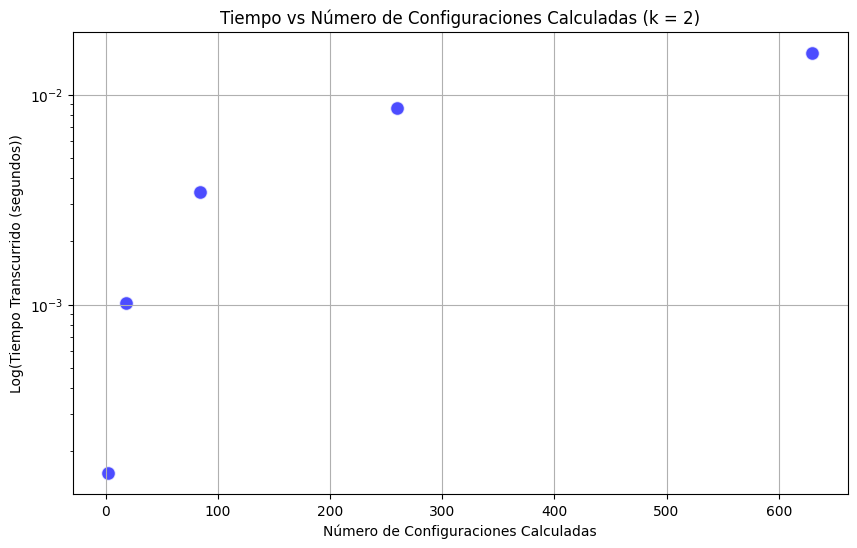

In [12]:
df = pd.read_csv('qcoloration_results_naive_deterministic.csv')
df1 = df[df['size'] == 2]
df2 = df[df['size'] == 3]
plt.figure(figsize=(10, 6))

plt.yscale('log')

plt.scatter(df1['count'], df1['time_elapsed'], c='blue', alpha=0.7, edgecolors='w', s=100)
plt.xlabel('Número de Configuraciones Calculadas')
plt.ylabel('Log(Tiempo Transcurrido (segundos))')
plt.title('Tiempo vs Número de Configuraciones Calculadas (k = 2)')

plt.grid(True)
plt.show()

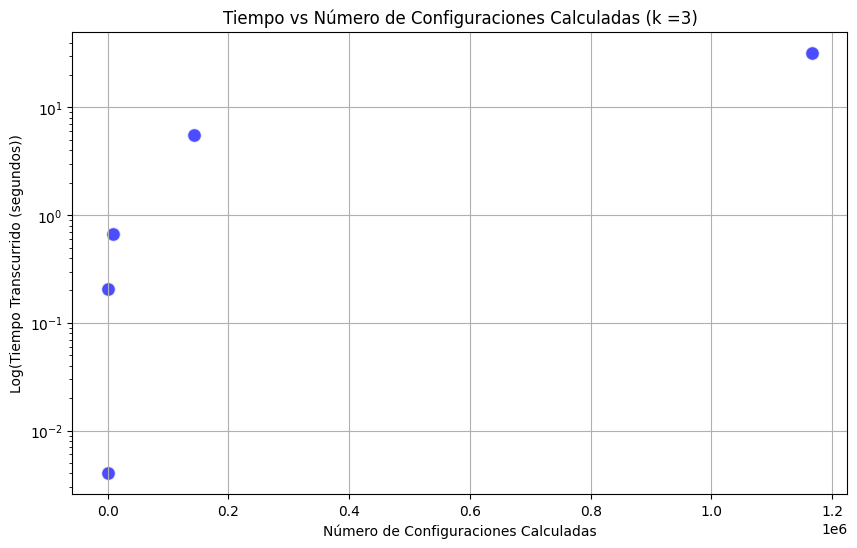

In [13]:
df = pd.read_csv('qcoloration_results_naive_deterministic.csv')
df1 = df[df['size'] == 2]
df2 = df[df['size'] == 3]
plt.figure(figsize=(10, 6))

plt.yscale('log')

plt.scatter(df2['count'], df2['time_elapsed'], c='blue', alpha=0.7, edgecolors='w', s=100)
plt.xlabel('Número de Configuraciones Calculadas')
plt.ylabel('Log(Tiempo Transcurrido (segundos))')
plt.title('Tiempo vs Número de Configuraciones Calculadas (k =3)')

plt.grid(True)
plt.show()

### Conteo aproximado usando un algoritmo "Naive" (Aleatorio)

In [14]:
class QColorationCounterNaive:
    def __init__(self, model, n_trials):
        self.model = model
        self.n_trials = n_trials

    def estimate_q_colorations(self):
        num_nodes = self.model.graph.num_nodes
        q = self.model.q
        valid_colorings_count = 0

        for _ in range(self.n_trials):
            random_configuration = np.random.randint(0, q, size=num_nodes)
            self.model.graph.node_states = random_configuration

            if self.is_feasible():
                valid_colorings_count += 1

        k = num_nodes
        estimate = (valid_colorings_count / self.n_trials) * (q ** k)
        return estimate

    def is_feasible(self):
        for node in range(self.model.graph.num_nodes):
            node_state = self.model.graph.get_state(node)
            neighbors = self.model.graph.get_neighbors(node)
            for neighbor in neighbors:
                if self.model.graph.get_state(neighbor) == node_state:
                    return False
        return True

In [15]:
with open('qcoloration_results_naive_randomized.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["size", "q", "count", "time_elapsed"])

        for size in range(2, 6):
            for q in range(2, 16):
                qcol_model = QColoration(graph=Graph.create_lattice(size=size), q=q, config_type="random")
                qcol_counter = QColorationCounterNaive(qcol_model, n_trials=500000)
                start_time = time.time()
                count = int(qcol_counter.estimate_q_colorations())
                end_time = time.time()
                time_elapsed = end_time - start_time

                print(f"size:{size:<5} q:{q:<5} count:{count:<10.4f} time_elapsed:{time_elapsed:.4f}")
                
                writer.writerow([size, q, count, time_elapsed])

size:2     q:2     count:2.0000     time_elapsed:4.5414
size:2     q:3     count:18.0000    time_elapsed:4.4585
size:2     q:4     count:84.0000    time_elapsed:4.6537
size:2     q:5     count:260.0000   time_elapsed:4.5472
size:2     q:6     count:629.0000   time_elapsed:5.2244
size:2     q:7     count:1301.0000  time_elapsed:4.9200
size:2     q:8     count:2406.0000  time_elapsed:5.8686
size:2     q:9     count:4102.0000  time_elapsed:5.2251
size:2     q:10    count:6579.0000  time_elapsed:5.3462
size:2     q:11    count:9990.0000  time_elapsed:5.1474
size:2     q:12    count:14648.0000 time_elapsed:4.9614
size:2     q:13    count:20769.0000 time_elapsed:5.0120
size:2     q:14    count:28549.0000 time_elapsed:5.8670
size:2     q:15    count:38508.0000 time_elapsed:5.3919
size:3     q:2     count:2.0000     time_elapsed:4.7500
size:3     q:3     count:245.0000   time_elapsed:4.6156
size:3     q:4     count:9670.0000  time_elapsed:4.8149
size:3     q:5     count:142074.0000 time_elapse

En la anterior aproximación se evidencia como en determinados casos el número de q-Coloraciones se torna 0, pues no se logró encontrar ninguna, esto lleva a que se necesiten muchas iteraciones y en el libro de Haggstrom se probó que este algortimo crece de forma exponencial.

### Conteo aproximado usando el esquema aleatorizado con MCMC

La ide es realizar la aproximación usando el algoritmo de MCMC, con los siguientes valores: $3\leq k\leq20\ \text{ y }\ 2\leq q\leq 15 $. Sin embargo el tiempo de ejecución en python, con la implementación planteada no fue exitoso. Así mismo para el conteo exacto usando el polinomio cromático a través del paquete networkx, el tiempo de ejecución era demasiado. Para esto se vio necesario usar Julia y a través de JuliaCall se integró a este mismo notebook. Sin embargo usaremos la implementación en python para ver que el tiempo de ejecución será significativamente más lento que en Julia y además se ilustrará el algoritmo de aproximación aleatorizado usando el modulo de visualización ya descrito en esta implementación.

In [22]:
qcoloration_model = GraphFactory.create_model("qcoloration", size=3, q = 3)
start_time = time.time()
print(qcoloration_model.get_configuration_counter().count_mcmc(eps = 10))
end_time = time.time()
time_elapsed = end_time - start_time
print(time_elapsed)

Number of iterations in MCMC simulation: 915
Number of samples generated: 72
236
33.876317262649536


El anterior algoritmo demoró un total de 33 segundos, mientras que en Julia demoró 0.0220716673 segundos.

Number of iterations in MCMC simulation: 524
Number of samples generated: 2


0

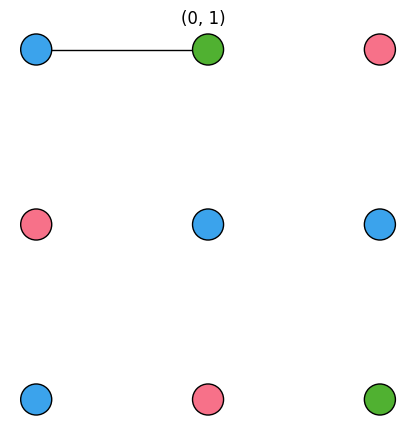

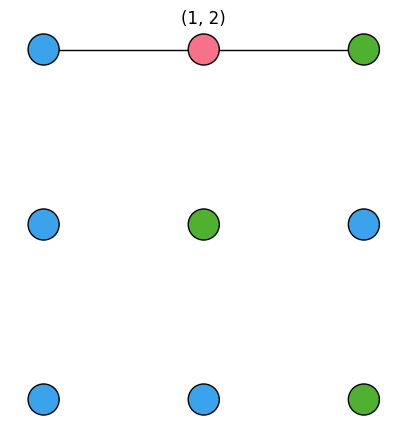

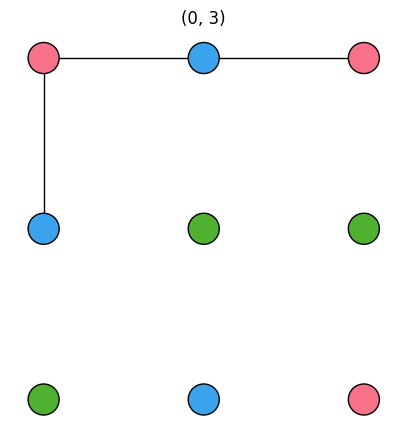

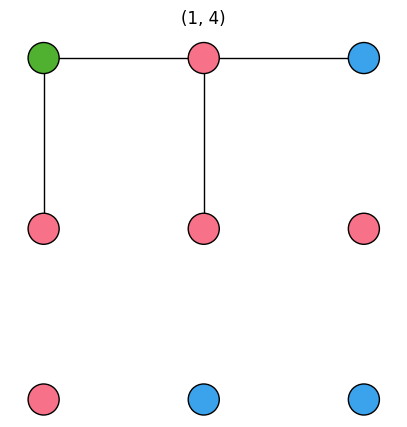

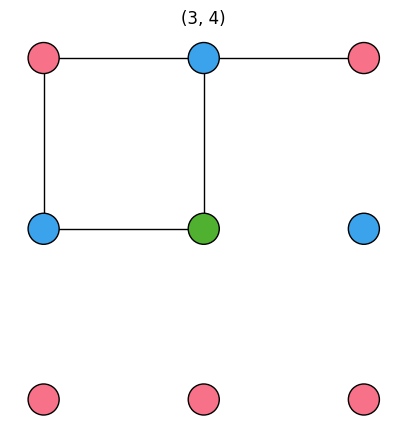

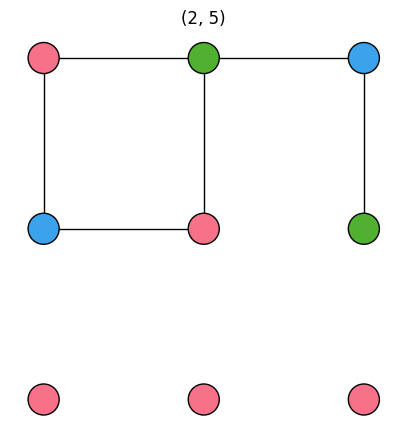

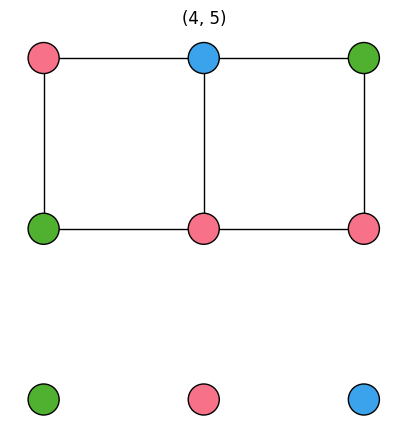

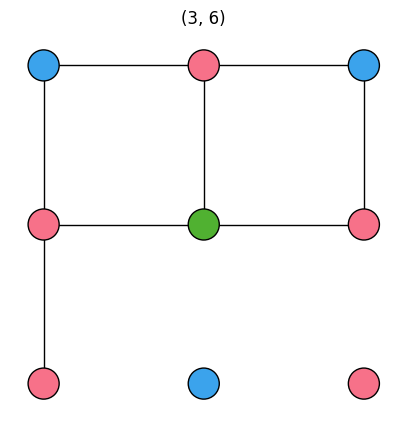

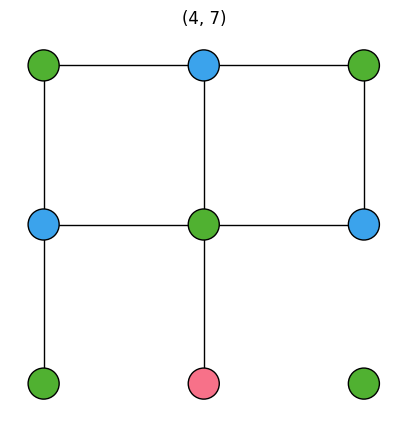

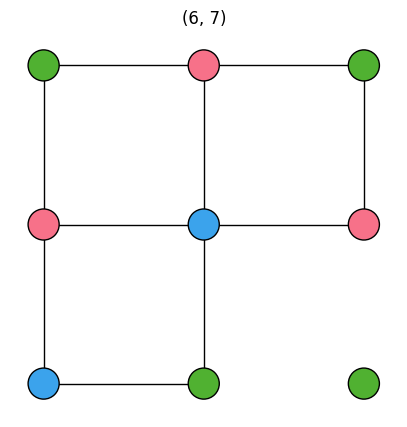

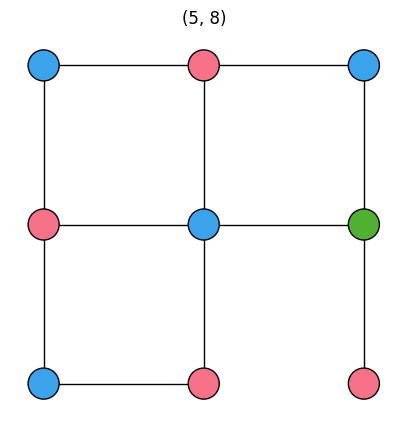

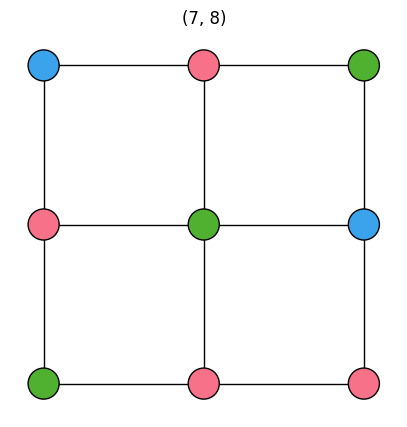

In [42]:
qcoloration_model.get_configuration_counter().count_mcmc(eps = 50, draw = True)

Ahora veamos la implementación en Julia, que fue la finalmente usada.

Primero, usamos las siguientes librerias.

In [43]:
%%julia
using SimpleGraphs
using Statistics
using StatsBase
using CSV
using DataFrames
using Dates

Ahora, para el MCMC se hizo lo siguiente:

In [45]:
%%julia
mutable struct QColorationConfigurations
    n::Int64                
    lattice::UndirectedGraph{Int64}
    values::Vector{Int64}
    selected_node::Int64 
    iteration::Int64   
    q::Int64              

    function QColorationConfigurations(n::Int64, q::Int64)
        lattice = IntGraph(n * n)  
        values = [i % q + 1 for i in 1:(n * n)]
        selected_node = 1
        iteration = 0
        return new(n, lattice, values, selected_node, iteration, q)
    end
end

function increment_iteration!(model::QColorationConfigurations)
    model.iteration += 1
end

function select_node!(model::QColorationConfigurations)
    model.selected_node = (model.selected_node - 1) % NV(model.lattice) + 1
    node = model.selected_node
    model.selected_node += 1
    return node
end

function get_neighbors(model::QColorationConfigurations, node::Int64)
    return neighbors(model.lattice, node)
end

function get_state(model::QColorationConfigurations, node::Int64)
    return model.values[node]
end

function set_state!(model::QColorationConfigurations, node::Int64, new_state::Int64)
    model.values[node] = new_state
end

function conditional_distribution(node::Int64, model::QColorationConfigurations)
    neighbors = get_neighbors(model, node)

    banned_colors = Set(get_state(model, neighbor) for neighbor in neighbors)

    available_colors = setdiff(1:model.q, banned_colors)
    
    if !isempty(available_colors)
        new_state = rand(available_colors)
        return new_state
    else
        return NaN
    end
end

function update_state!(model::QColorationConfigurations)
    increment_iteration!(model)
    node = select_node!(model)
    new_state = conditional_distribution(node, model)
    if !isnan(new_state)
        set_state!(model, node, new_state)
    end
end

function get_sample!(model::QColorationConfigurations, i::Int64 = 10^5; print_progress::Bool = false)
    if print_progress
        progress_points = [i ÷ 10, 2 * i ÷ 10, 3 * i ÷ 10, 4 * i ÷ 10, 5 * i ÷ 10, 6 * i ÷ 10, 7 * i ÷ 10, 8 * i ÷ 10, 9 * i ÷ 10]
    end
    
    for j in 1:i
        update_state!(model)
        
        if print_progress && j in progress_points
            println("Iteration: $j / $i")
        end
    end
    
    if print_progress
        println("Iteration: $i / $i (completed)")
    end
end



get_sample! (generic function with 2 methods)

Ahora, tenemos las funciones para calcular las cotas:

In [146]:
%%julia
function adjust_q(d, q, bound)
    if bound == "jerrum"
        if q <= 2 * d
            q_min = 2 * d + 1
            adjustment_factor = q_min / q^(1/1)
            return q_min, adjustment_factor
        end
    elseif bound == "haggstrom"
        if q <= 2 * d^2
            q_min = 2 * d^2 + 1
            adjustment_factor = q_min / q^(1/1)
            return q_min, adjustment_factor
        end
    end
    return q, 1
end


function mcmc_iterations_haggstrom(n, q, d, epsilon)
    q, adjustment_factor = adjust_q(d, q, "haggstrom")
    numerator = 2 * log(n) + log(1/epsilon) + log(8)
    denominator = log(q / (2 * d^2))
    return Int(floor(n * (numerator / denominator + 1) * adjustment_factor))
end

function simulation_number_haggstrom(n, d, epsilon)
    numerator = 48 * d^3 * n^3
    denominator = epsilon^2
    return Int(floor(numerator / denominator))
end


function mcmc_iterations_jerrum(n, q, d, l, epsilon)
    q, adjustment_factor = adjust_q(d, q, "jerrum")
    numerator = q * n * log((4 * n * l) / epsilon)
    denominator = q - 2 * d
    return Int(floor((numerator / denominator) * adjustment_factor))
end

function simulation_number_jerrum(n, d, l, epsilon)
    numerator = 50 * l^2
    denominator = epsilon^2
    return Int(floor(numerator / denominator))
end

function mean_2_3(data::Vector{Float64}, num_closest=20)
    
    most_frequent = mode(data)

    distances = abs.(data .- most_frequent)
    
    sorted_indices = sortperm(distances)
    closest_indices = sorted_indices[1:min(num_closest, length(data))]
    
    closest_elements = data[closest_indices]
    
    return BigInt(floor(mean(closest_elements)))
end


mean_2_3 (generic function with 3 methods)

Ahora, el esquema de aproximación aleatorizado:

In [49]:
%%julia
function approximate_count(size::Int64, q::Int64, eps::Float64 = 1e-2, bound::String = "jerrum", reps = 30)
    n = BigInt(size^2)
    edge_list = Vector{Tuple{Int, Int}}()
    
    for i in 1:size
        for j in 1:size
            node = (i - 1) * size + j
            if i > 1
                push!(edge_list, (node, node - size)) 
            end
            if j > 1
                push!(edge_list, (node, node - 1))  
            end
        end
    end
    
    l = length(edge_list)

    if bound == "jerrum"
        num_samples = simulation_number_jerrum(n, 4,l, eps)
        num_iterations = mcmc_iterations_jerrum(n,q,4,l,eps)
    elseif bounf == "haggstrom"
        num_samples = simulation_number_haggstrom(n, 4, eps)
        num_iterations = mcmc_iterations_haggstrom(n,q,4,eps)       
    end

    println("Number of iterations in MCMC simulation: ", num_iterations)
    println("Number of samples generated: ", num_samples)
    
    estimates = Float64[]
    z_0 = BigInt(q) ^ n  
    time = 0
    
    
    for _ in 1:reps
        disconnected_model = QColorationConfigurations(size, q)
        ratios = Float64[]
        elapsed_time = @elapsed begin
            for edge in edge_list
                indicator_function_counting = 0.0
        
        
                for _ in 1:num_samples
                    get_sample!(disconnected_model, num_iterations)
                    
                    if disconnected_model.values[edge[1]] != disconnected_model.values[edge[2]]
                        indicator_function_counting += 1
                    end
                end
                
                add!(disconnected_model.lattice, edge[1], edge[2])
                
                push!(ratios, indicator_function_counting / num_samples)
            end
            push!(estimates, BigInt(floor(z_0 * prod(ratios))))
        end
        time += elapsed_time
        
    end
    
    time /= 30

    if (reps % 3 != 0)
        close_elements = 1
    else
        close_elements =  BigInt(floor(2*reps/3))
    end
    
    return mean_2_3(estimates,  close_elements), time, num_samples, num_iterations

end

approximate_count (generic function with 4 methods)

Se corrieó el siguiente código y los resultados fueron guardados dado el costo computacional:

Veamos los resultados obtenidos:
#### q-Coloraciones para 3x3

In [65]:
file_path = 'qcoloration_results_MCMC_k3_reps1.csv'
data_3 = pd.read_csv(file_path)
data_3['count'] = data_3['count'].astype('int64')
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)   
data_3

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,3,2.0,1.0,1,7200,2211,3.369896
1,3,3.0,1.0,236,7200,1474,2.332791
2,3,4.0,1.0,9555,7200,1105,1.852260
3,3,5.0,1.0,142504,7200,884,1.585376
4,3,6.0,1.0,1170664,7200,737,1.380147
5,3,7.0,1.0,6455105,7200,631,1.253884
6,3,8.0,1.0,27441991,7200,552,1.135303
7,3,9.0,1.0,93873529,7200,491,1.107247
8,3,10.0,1.0,288467793,7200,273,0.648896
9,3,11.0,1.0,764918287,7200,200,0.601962


Veamos la comparación con los valores exactos:

In [67]:
df = pd.read_csv('q_coloration_results_mathematica.csv')
mask = df['size'] == 3
data_3_exact = df[mask]
data_3['exact_count'] = data_3_exact['count'].astype('int64')
data_3['relative error'] = abs(data_3['exact_count']-data_3['count'])/data_3['exact_count']*100
data_3

,size,q,eps,count,num_samples,num_iterations,time_elapsed,exact_count,relative error
0,3,2.0,1.0,1,7200,2211,3.369896,2,50.000000
1,3,3.0,1.0,236,7200,1474,2.332791,246,4.065041
2,3,4.0,1.0,9555,7200,1105,1.852260,9612,0.593009
3,3,5.0,1.0,142504,7200,884,1.585376,142820,0.221258
4,3,6.0,1.0,1170664,7200,737,1.380147,1166910,0.321704
5,3,7.0,1.0,6455105,7200,631,1.253884,6464682,0.148143
6,3,8.0,1.0,27441991,7200,552,1.135303,27350456,0.334674
7,3,9.0,1.0,93873529,7200,491,1.107247,95004072,1.189994
8,3,10.0,1.0,288467793,7200,273,0.648896,283982490,1.579429
9,3,11.0,1.0,764918287,7200,200,0.601962,754324670,1.404384


Podemos observas que el error más alto es dado lo pequeño del valor (2), para los demás casos la aproximación tiene menos del 2% de error, considerando que es un muy buen resultado.

Veamos los resultados obtenidos:
#### q-Coloraciones para 4x4

In [103]:
file_path = 'qcoloration_results_MCMC_k4_reps1.csv'
data_4 = pd.read_csv(file_path)
data_4['count'] = data_4['count'].astype('int64')  
data_4

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,4,2.0,1.0,2,28800,4754,85.712635
1,4,3.0,1.0,7898,28800,3169,141.556275
2,4,4.0,1.0,6194563,28800,2377,115.566552
3,4,5.0,1.0,821741774,28800,1901,101.795272
4,4,6.0,1.0,37720560799,28800,1584,83.622518
5,4,7.0,1.0,872679476153,28800,1358,77.888768
6,4,8.0,1.0,11892474181272,28800,1188,64.797838
7,4,9.0,1.0,108970963469856,28800,1056,33.897013
8,4,10.0,1.0,814275332803364,28800,586,11.582297
9,4,11.0,1.0,4709387886816157,28800,430,11.052604


In [111]:
mask = df['size'] == 4
data_4_exact = df[mask]
data_4_exact = data_4_exact.reset_index()
data_4['exact_count'] = data_4_exact['count'].astype('int64')
data_4['relative error'] = abs(data_4['exact_count']-data_4['count'])/data_4['exact_count']*100
data_4

,size,q,eps,count,num_samples,num_iterations,time_elapsed,exact_count,relative error
0,4,2.0,1.0,2,28800,4754,85.712635,2,0.000000
1,4,3.0,1.0,7898,28800,3169,141.556275,7812,1.100870
2,4,4.0,1.0,6194563,28800,2377,115.566552,6000732,3.230123
3,4,5.0,1.0,821741774,28800,1901,101.795272,828850160,0.857620
4,4,6.0,1.0,37720560799,28800,1584,83.622518,38128724910,1.070490
5,4,7.0,1.0,872679476153,28800,1358,77.888768,856858754052,1.846363
6,4,8.0,1.0,11892474181272,28800,1188,64.797838,11722360851992,1.451187
7,4,9.0,1.0,108970963469856,28800,1056,33.897013,111647093496192,2.396954
8,4,10.0,1.0,814275332803364,28800,586,11.582297,807567269568570,0.830651
9,4,11.0,1.0,4709387886816157,28800,430,11.052604,4707230299664420,0.045836


En el caso 4x4, vemos que el resultado es aún mejor.

#### q-Coloraciones para 5x5

In [115]:
file_path = 'qcoloration_results_MCMC_k5_reps1.csv'
data_5 = pd.read_csv(file_path).iloc[::-1].reset_index(drop=True)
data_5['count'] = data_5['count'].apply(lambda x: int(x))  
mask = df['size'] == 5
data_5_exact = df[mask]
data_5_exact = data_5_exact.reset_index()
data_5['exact_count'] = data_5_exact['count'].apply(lambda x: int(x))
data_5['relative error'] = abs(data_5['exact_count']-data_5['count'])/data_5['exact_count']*100
data_5

,size,q,eps,count,num_samples,num_iterations,time_elapsed,exact_count,relative error
0,5,2.0,10.0,1,800,6066,4.113337,2,50.0
1,5,3.0,10.0,668144,800,4044,2.966390,580986,15.001738
2,5,4.0,10.0,24607745695,800,3033,2.421613,20442892764,20.37311
3,5,5.0,10.0,47635265406378,800,2426,2.008020,50820390410180,6.267415
4,5,6.0,10.0,24089901440073784,800,2022,1.791892,21977869327169310,9.609813
5,5,7.0,10.0,2894733559408642560,800,1733,1.567157,3031776844080257742,4.52023
6,5,8.0,10.0,192432555189409054720,800,1516,1.444430,189586772101347563096,1.501045
7,5,9.0,10.0,6401398992191710298112,800,1348,1.516833,6660747304179593671944,3.893682
8,5,10.0,10.0,135244014409869206487040,800,748,0.878026,151086899096935604867610,10.485942
9,5,11.0,10.0,2440496965766681341198336,800,549,0.871543,2432514752747773742479970,0.328147


A medida que avanzamos comienza a aumentar el error pues el epsilos es más grande y los pasos, por tanto, son menores.

#### q-Coloraciones para 6x6

In [116]:
file_path = 'qcoloration_results_MCMC_k6_reps1.csv'
data_6 = pd.read_csv(file_path).iloc[::-1].reset_index(drop=True)
data_6['count'] = data_6['count'].apply(lambda x: int(x))  
mask = df['size'] == 6
data_6_exact = df[mask]
data_6_exact = data_6_exact.reset_index()
data_6['exact_count'] = data_6_exact['count'].apply(lambda x: int(x))
data_6['relative error'] = abs(data_6['exact_count']-data_6['count'])/data_6['exact_count']*100
data_6

,size,q,eps,count,num_samples,num_iterations,time_elapsed,exact_count,relative error
0,6,2.0,10.0,1,1800,9858,22.169698,2,50.0
1,6,3.0,10.0,76553553,1800,6572,15.804351,101596896,24.649713
2,6,4.0,10.0,365654351611846,1800,4929,12.541461,380053267505964,3.788657
3,6,5.0,10.0,32965054129118711808,1800,3943,9.943466,32921147633979091400,0.133369
4,6,6.0,10.0,224599465835761015717888,1800,3286,8.769866,223479277713132418833390,0.501249
5,6,7.0,10.0,321324604382232695093067776,1800,2816,7.589221,286359202456130400260611752,12.210329
6,6,8.0,10.0,108831556474836926866661572608,1800,2464,7.011042,115702677512781649307005417016,5.938602
7,6,9.0,10.0,21733783267179278244164019421184,1800,2190,6.792541,20172922880766721483554814468464,7.737403
8,6,10.0,10.0,1795332663184469684871218973376512,1800,1217,3.899044,1859669891770248856476997904547450,3.459605
9,6,11.0,10.0,105847520153204359783302540300386304,1800,892,3.661654,104094652664259277009814001042264080,1.683917


#### q-Coloraciones para 7x7

In [117]:
file_path = 'qcoloration_results_MCMC_k7_reps1.csv'
data_7 = pd.read_csv(file_path).iloc[::-1].reset_index(drop=True)
data_7['count'] = data_7['count'].apply(lambda x: int(x))  
mask = df['size'] == 7
data_7_exact = df[mask]
data_7_exact = data_7_exact.reset_index()
data_7['exact_count'] = data_7_exact['count'].apply(lambda x: int(x))
data_7['relative error'] = abs(data_7['exact_count']-data_7['count'])/data_7['exact_count']*100
data_7

,size,q,eps,count,num_samples,num_iterations,time_elapsed,exact_count,relative error
0,7,2.0,30.0,1,392,12517,8.689114,2,50.0
1,7,3.0,30.0,27134446242,392,8345,5.497378,41869995708,35.193578
2,7,4.0,30.0,31906597078915440640,392,6258,4.428703,38557892676685306572,17.250153
3,7,5.0,30.0,283435380081341394600329216,392,5007,3.990581,225313329780157255086187280,25.796099
4,7,6.0,30.0,38705449914694752210245352685568,392,4172,3.182932,40087345104573458097599768622030,3.447211
5,7,7.0,30.0,775466702967523327636468770619260928,392,3576,2.974551,722022905627873731429602000554432412,7.401953
6,7,8.0,30.0,2923986924134375516518470120365480738816,392,3129,2.998072,2664533696267986042969615868160108207608,9.737285
7,7,9.0,30.0,3412427083133580999050800343839281694900224,392,2781,2.926734,3101594610276176352440997042418550841885312,10.021699
8,7,10.0,30.0,1557533045460046355871124394632608776206680064,392,1545,1.771848,1505933744255415534793832118356329294462055610,3.426399
9,7,11.0,30.0,399012114231249906157538109346613082189692141568,392,1133,1.474251,368879277984660057018944113007596468930552762460,8.168753


k = 7 es el último caso con el que tenemos comparación teórica. Para este punto el error relativo ya es más grande, sin embargo podemos notar que estamos en el mismo orden de magnitud, situación importante para los números tan grandes que se están manejando, por lo que podemos asumir que los números para los casos siguientes podrían estar en el mismo orden de magnitud, pero su error relativo comenzará a aumentar muy significativamente.

#### q-Coloraciones para 8x8

In [118]:
file_path = 'qcoloration_results_MCMC_k8_reps1.csv'
data_8 = pd.read_csv(file_path)
data_8['count'] = data_8['count'].apply(lambda x: int(x))  
data_8

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,8,10.0,40.0,77562004501822202013592576508667276637388565147474718621696,392,2103,2.804320
1,8,11.0,40.0,113608834371858944097346592176551277550330647788246913760886784,392,1542,2.885831
2,8,12.0,40.0,51048207976434639089984138884002190487351202069284438803195363328,392,1262,2.378130
3,8,13.0,40.0,23395687121580776748928278288964086597327713728374805320057602703360,392,1094,2.234693
4,8,14.0,40.0,6955745766157473192879672107342036532801466012491212272057364479213568,392,981,2.187469
5,8,15.0,40.0,746419924300456651528801830724801253006556697186824981388784980904116224,392,901,2.105004


#### q-Coloraciones para 9x9

In [119]:
file_path = 'qcoloration_results_MCMC_k9_reps1.csv'
data_9 = pd.read_csv(file_path)
data_9['count'] = data_9['count'].apply(lambda x: int(x))  
data_9

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,9,10.0,40.0,226776470588539834782938003445076329255126199516854928921613755591046463488,648,2859,9.376370
1,9,11.0,40.0,2463426188785041249765560258830612768863649843632706744283554721927905599815680,648,2097,8.442430
2,9,12.0,40.0,8889343899251538607130412658298785194327234947402479669281923930246460747517263872,648,1715,8.171130
3,9,13.0,40.0,18251235097907465369019936318787242938790054760822899312332851321319866904579323985920,648,1487,7.977405
4,9,14.0,40.0,20552863398742278357993534783301534820920880504127625609751230160693522155687823758327808,648,1334,7.073851
5,9,15.0,40.0,9994767802406643063612383760338847946345159324823909272196047899679436940517153111028006912,648,1225,7.692792


#### q-Coloraciones para 10x10

In [120]:
file_path = 'qcoloration_results_MCMC_k10_reps1.csv'
data_10 = pd.read_csv(file_path)
data_10['count'] = data_10['count'].apply(lambda x: int(x))  
data_10

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,10,10.0,50.0,70341791259633158106590357841757203637378086068504439935507280075480954528612943361094975488,648,3636,14.486866
1,10,11.0,50.0,5943431221113282132878937106703781622665787610672700633005569831800435375987230617917371055079424,648,2666,14.101601
2,10,12.0,50.0,135013725613426595520743889166328027766373803170430508492350179057309832354508254554590814526880350208,648,2181,12.011555
3,10,13.0,50.0,1112601408150868037665634451962679154265521094835780317236208071375484320033609835917136916723722365173760,648,1890,10.879430
4,10,14.0,50.0,8532457512193991335110658227344523263459839553588553769861591018561751518780929184772250143343351778439593984,648,1696,9.940130
5,10,15.0,50.0,16502814976741247645786582373086126924024482052305318021174649228441931661877467392111624351173940329190237667328,648,1558,9.418502


#### q-Coloraciones para 11x11

In [121]:
file_path = 'qcoloration_results_MCMC_k11_reps1.csv'
data_11 = pd.read_csv(file_path)
data_11['count'] = data_11['count'].apply(lambda x: int(x))  
data_11

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,11,13.0,50.0,16109934879384792157417090519286160808948899105936239920060126541315162422940442366002327996787062839721275769603116967498088448,968,2410,23.659413
1,11,14.0,50.0,423729924369572768304060699609083367960457069715029941358600102147010787640347841351277526418890791102811382644568098945308437774336,968,2163,18.769416
2,11,15.0,50.0,6408509426079484098954843762602257886500917101094295179090328084577395095102981709949041730114168551788576773786553448907205275883143168,968,1987,20.123408


#### q-Coloraciones para 12x12

In [122]:
file_path = 'qcoloration_results_MCMC_k12_reps1.csv'
data_12 = pd.read_csv(file_path)
data_12['count'] = data_12['count'].apply(lambda x: int(x))  
data_12

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,12,13.0,80.0,20853784424682750541902600101737424931387362020262153425430116015724571104952020847651292842526969875819785986629452366669852593285020856732119241588736,544,2826,22.845871
1,12,14.0,80.0,4442830246985167816941705594370918220970868658952841202813686290361247918597287111953649817537062665286470534759995005192941147937479384800938943849416359936,544,2536,19.795873
2,12,15.0,80.0,269665370688829037508170274257275550416428707911253606562415196116241760077089636267984306973810681937765015455011458328928705134749541040711813314522342339117056,544,2329,19.588620


#### q-Coloraciones para 13x13

In [123]:
file_path = 'qcoloration_results_MCMC_k13_reps1.csv'
data_13 = pd.read_csv(file_path)
data_13['count'] = data_13['count'].apply(lambda x: int(x))  
data_13

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,13,15.0,80.0,2126891996773153528718381060184299655849178073586948576406452456340067668519678346454962143302320207502110149764758579156070978433557973469895908730169068324778319890504554227711418526859264,760,2852,32.118518


#### q-Coloraciones para 14x14

In [124]:
file_path = 'qcoloration_results_MCMC_k14_reps1.csv'
data_14 = pd.read_csv(file_path)
data_14['count'] = data_14['count'].apply(lambda x: int(x))  
data_14

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,14,15.0,80.0,3750238479770333101007628107370900951780091153258362903585560492746005551364851840921153086986996810035510908399384357292802789609742989723928259668150289481342427628259250301563257431395796527441697856575204647090782208,1035,3435,63.732121


#### q-Coloraciones para 15x15

In [125]:
file_path = 'qcoloration_results_MCMC_k15_reps1.csv'
data_15 = pd.read_csv(file_path)
data_15['count'] = data_15['count'].apply(lambda x: int(x))  
data_15

,size,q,eps,count,num_samples,num_iterations,time_elapsed
0,15,15.0,80.0,995171619501890088965460871220565466118396560237074019713664153282404877715198869523584244015844858750065024666543400819575978111694404475464607912677957440548993162546307510290032350415191354670506818150086448103187775904596081568893050452908150095872,1378,4079,122.902272


Veamos como se comportó el tiempo de ejecución para 3x3:

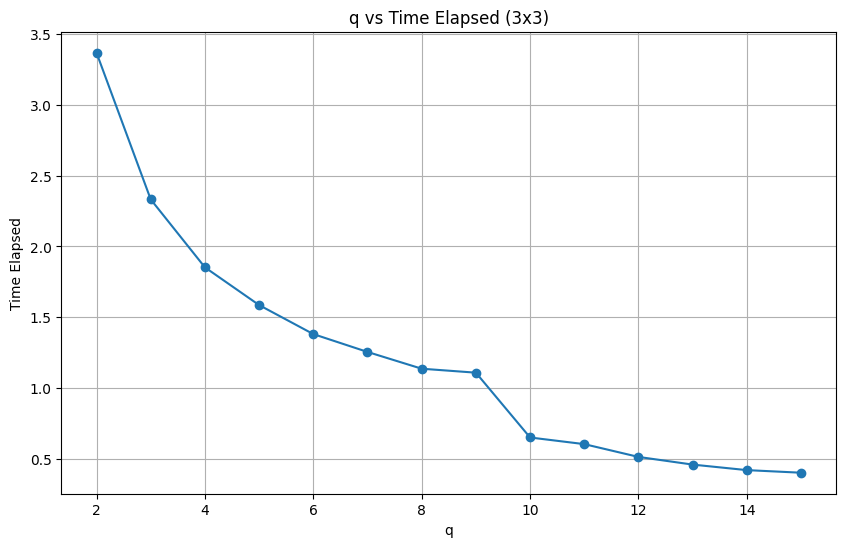

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(data_3['q'], data_3['time_elapsed'], marker='o', linestyle='-')
plt.xlabel('q')
plt.ylabel('Time Elapsed')
plt.title('q vs Time Elapsed (3x3)')
plt.grid(True)
plt.show()

Se puede observar el arreglo realizado a la cota descrita por Jerrum. Muy seguramente se pudo elegirvalores inferiores a los primeros puntos antes de 9.

### Conteo exacto de q-Coloraciones usando el polinomio cromático del grafo
Se usaron herramientas como el pquete networkx de Python y el paquete SimpleGraphAlgorithms de Julia. Al final para poder obtener la mayor cantidad de valores exactos posibles, se hizo uso de Mathematica.

In [16]:
qcoloration_model = GraphFactory.create_model("qcoloration", size=2)
count = qcoloration_model.get_qcoloration_counting()
print(count)

Calculating chromatic polynomial...
18


In [ ]:
with open('qcoloration_results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["size", "q", "count", "time_elapsed"])

    for size in range(3, 5):
        x = sp.symbols('x')
        qcoloration_model = GraphFactory.create_model("qcoloration", size=size)
        start_time = time.time()
        chromatic_polynomial = qcoloration_model.get_chromatic_polynomial()
        end_time = time.time()
        time_elapsed = end_time - start_time
        for q in range(2, 16):
            count = int(chromatic_polynomial(q))

            print(f"size:{size:<5} q:{q:<5} count:{count:<10} time_elapsed:{time_elapsed:.4f}")
            
            writer.writerow([size, q, count, time_elapsed])

A continuación, los datos exactos obtenidos usando el polinomio cromático en Mathematica.

In [20]:
df = pd.read_csv('q_coloration_results_mathematica.csv')
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)  
df

,size,q,count,time_elapsed
0,3,2,2,0.004010
1,3,3,246,0.004010
2,3,4,9612,0.004010
3,3,5,142820,0.004010
4,3,6,1166910,0.004010
5,3,7,6464682,0.004010
6,3,8,27350456,0.004010
7,3,9,95004072,0.004010
8,3,10,283982490,0.004010
9,3,11,754324670,0.004010


## Conteo aproximado para el modelo Hard-Core

### Conteo aproximado usando un algoritmo "Naive" (Deterministico)
A continuación se ejecutará el algoritmo naive para el caso de Hard-Core, esto nos va a permitir obtener algunos valores exactos para comparar posteriormente. Después de 5 el tiempo de ejecución supera las dos horas.

In [263]:
class HardcoreCounter:
    def __init__(self, model):
        self.model = model
    
    def count_configurations(self):
        num_nodes = self.model.graph.num_nodes
        
        count = 0
        for configuration in itertools.product([0, 1], repeat=num_nodes):
            self.model.graph.node_states = np.array(configuration)
            if self.is_feasible():
                count += 1
        
        return count
    
    def is_feasible(self):
        for node in range(self.model.graph.num_nodes):
            node_state = self.model.graph.get_state(node)
            neighbors = self.model.graph.get_neighbors(node)
            if node_state == 1:
                for neighbor in neighbors:
                    if self.model.graph.get_state(neighbor) == 1:
                        return False
        return True


In [269]:
with open('hardcore_results_naive_deterministic.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["size", "q", "count", "time_elapsed"])

        for size in range(2, 6):
            
            hardcore_model = Hardcore(graph=Graph.create_lattice(size=size), config_type="random")
            counter = HardcoreCounter(hardcore_model)
            start_time = time.time()
            count = counter.count_configurations()
            end_time = time.time()
            time_elapsed = end_time - start_time

            print(f"size:{size:<5} q:{q:<5} count:{count:<10.4f} time_elapsed:{time_elapsed:.4f}")
                
            writer.writerow([size, q, count, time_elapsed])

size:2     q:15    count:7.0000     time_elapsed:0.0003
size:3     q:15    count:63.0000    time_elapsed:0.0104
size:4     q:15    count:1234.0000  time_elapsed:0.4200
size:5     q:15    count:55447.0000 time_elapsed:106.9462


### Conteo aproximado usando un algoritmo "Naive" (Aleatorio)

Vemos que al igual que las q-Coloraciones, después de un tamaño en particular (8 en este caso), es necesario correr demasiadas iteraciones.

In [272]:
import numpy as np

class HardcoreCounterNaive:
    def __init__(self, model, n_trials):
        self.model = model
        self.n_trials = n_trials

    def estimate_hardcore_configurations(self):

        num_nodes = self.model.graph.num_nodes
        valid_configurations_count = 0

        for _ in range(self.n_trials):
            random_configuration = np.random.randint(0, 2, size=num_nodes)
            self.model.graph.node_states = random_configuration

            if self.is_feasible():
                valid_configurations_count += 1

        k = num_nodes
        estimate = (valid_configurations_count / self.n_trials) * (2 ** k)
        return estimate

    def is_feasible(self):
        for node in range(self.model.graph.num_nodes):
            node_state = self.model.graph.get_state(node)
            neighbors = self.model.graph.get_neighbors(node)
            if node_state == 1:
                for neighbor in neighbors:
                    if self.model.graph.get_state(neighbor) == 1:
                        return False
        return True

In [276]:
with open('hardcore_results_naive_randomized.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["size", "q", "count", "time_elapsed"])

        for size in range(2, 10):
           
                model = Hardcore(graph=Graph.create_lattice(size=size), config_type="random")
                counter = HardcoreCounterNaive(model, n_trials=10000000)
                start_time = time.time()
                count = int(counter.estimate_hardcore_configurations())
                end_time = time.time()
                time_elapsed = end_time - start_time

                print(f"size:{size:<5} q:{q:<5} count:{count:<10.4f} time_elapsed:{time_elapsed:.4f}")
                
                writer.writerow([size, q, count, time_elapsed])

size:2     q:15    count:7.0000     time_elapsed:86.6108
size:3     q:15    count:63.0000    time_elapsed:93.7254
size:4     q:15    count:1235.0000  time_elapsed:90.4473
size:5     q:15    count:55411.0000 time_elapsed:90.8026
size:6     q:15    count:5868643.0000 time_elapsed:90.5590
size:7     q:15    count:1182194902.0000 time_elapsed:92.4513
size:8     q:15    count:0.0000     time_elapsed:92.2223
size:9     q:15    count:0.0000     time_elapsed:90.6545


### Conteo aproximado usando el algoritmo con MCMC

Se realizará la aproximación usando el algoritmo de MCMC, con los siguientes valores: $3\leq k\leq20$.

Al igual que en las q-coloraciones, se prefirió realizar los calculos usando la implementación en Julia, descrita a continuación:

In [130]:
%%julia
mutable struct HardCoreConfigurations
    n::Int64
    lattice::UndirectedGraph{Int64}
    values::Vector{Int64}
    selected_node::Int64
    iteration::Int64

    function HardCoreConfigurations(n::Int64)
        lattice = IntGraph(n * n)  # Inicializar lattice con n*n nodos
        values = [i % 2 == 0 ? 1 : 0 for i in 1:(n * n)]  # Nodos pares con 1, impares con 0
        selected_node = 1
        iteration = 0
        return new(n, lattice, values, selected_node, iteration)
    end
end

function increment_iteration!(model::HardCoreConfigurations)
    model.iteration += 1
end

function select_node!(model::HardCoreConfigurations)
    model.selected_node = (model.selected_node - 1) % NV(model.lattice) + 1
    node = model.selected_node
    model.selected_node += 1
    return node
end

function get_neighbors(model::HardCoreConfigurations, node::Int64)
    return neighbors(model.lattice, node)
end

function get_state(model::HardCoreConfigurations, node::Int64)
    return model.values[node]
end

function set_state!(model::HardCoreConfigurations, node::Int64, new_state::Float64)
    model.values[node] = new_state
end

function conditional_distribution(node::Int64, model::HardCoreConfigurations)
    neighbors = get_neighbors(model, node)
    
    coin = rand()

    if coin > 0.5
        neighbor_states = [get_state(model, neighbor) for neighbor in neighbors]
        if all(state -> state != 1, neighbor_states)
            return 1.0
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function update_state!(model::HardCoreConfigurations)
    increment_iteration!(model)
    node = select_node!(model)
    new_state = conditional_distribution(node, model)
    if !isnan(new_state)
        set_state!(model, node, new_state)
    end
end

function get_sample!(model::HardCoreConfigurations, i::Int64 = 10^5; print_progress::Bool = false)
    if print_progress
        progress_points = [i ÷ 10, 2 * i ÷ 10, 3 * i ÷ 10, 4 * i ÷ 10, 5 * i ÷ 10, 6 * i ÷ 10, 7 * i ÷ 10, 8 * i ÷ 10, 9 * i ÷ 10]
    end
    
    for j in 1:i
        update_state!(model)
        
        if print_progress && j in progress_points
            println("Iteration: $j / $i")
        end
    end
    
    if print_progress
        println("Iteration: $i / $i (completed)")
    end
end

get_sample! (generic function with 4 methods)

In [131]:
%%julia
function approximate_count(size::Int64, eps::Float64 = 1e-2, bound::String = "jerrum", reps = 30)
    n = BigInt(size^2)
    edge_list = Vector{Tuple{Int, Int}}()
    states = 2
    for i in 1:size
        for j in 1:size
            node = (i - 1) * size + j
            if i > 1
                push!(edge_list, (node, node - size)) 
            end
            if j > 1
                push!(edge_list, (node, node - 1))  
            end
        end
    end
    
    l = length(edge_list)

    if bound == "jerrum"
        num_samples = simulation_number_jerrum(n, 4,l, eps)
        num_iterations = mcmc_iterations_jerrum(n,states,4,l,eps)
    elseif bounf == "haggstrom"
        num_samples = simulation_number_haggstrom(n, 4, eps)
        num_iterations = mcmc_iterations_haggstrom(n,states,4,eps)       
    end

    println("Number of iterations in MCMC simulation: ", num_iterations)
    println("Number of samples generated: ", num_samples)
    
    estimates = Float64[]
    z_0 = BigInt(states) ^ n  
    time = 0
    
    
    for _ in 1:reps
        disconnected_model = HardCoreConfigurations(size)
        ratios = Float64[]
        elapsed_time = @elapsed begin
            for edge in edge_list
                indicator_function_counting = 0.0
        
        
                for _ in 1:num_samples
                    get_sample!(disconnected_model, num_iterations)
                    
                    if disconnected_model.values[edge[1]] == 0 || disconnected_model.values[edge[1]] != disconnected_model.values[edge[2]]
                        indicator_function_counting += 1
                    end
                end
                
                add!(disconnected_model.lattice, edge[1], edge[2])
                
                push!(ratios, indicator_function_counting / num_samples)
            end
            push!(estimates, BigInt(floor(z_0 * prod(ratios))))
        end
        time += elapsed_time
        
    end
    
    time /= 30

    if (reps % 3 != 0)
        close_elements = 1
    else
        close_elements =  BigInt(floor(2*reps/3))
    end
    
    return mean_2_3(estimates,  close_elements), time, num_samples, num_iterations

end

approximate_count (generic function with 8 methods)

Y se ejecutó el siguiente código y de la misma manera, se guardo por el costo computacional:

#### HardCore 2x2 a 10x10

In [135]:
file_paths = [
    'hardcore_results_MCMC_k2_reps1.csv',
    'hardcore_results_MCMC_k3_reps1.csv',
    'hardcore_results_MCMC_k4_reps1.csv',
    'hardcore_results_MCMC_k5_reps1.csv',
    'hardcore_results_MCMC_k6_reps1.csv',
    'hardcore_results_MCMC_k7_reps1.csv',
    'hardcore_results_MCMC_k8_reps1.csv',
    'hardcore_results_MCMC_k9_reps1.csv',
    'hardcore_results_MCMC_k10_reps1.csv'
]

# Leer los archivos CSV y almacenarlos en una lista
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Concatenar todos los DataFrames en uno solo
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['count'] = combined_df['count'].apply(lambda x: int(x))  
combined_df

,size,eps,count,num_samples,num_iterations,time_elapsed
0,2,0.9,7,987,690,0.011204
1,3,0.9,62,8888,2250,0.975560
2,4,4.0,1247,1800,3856,0.721081
3,5,8.0,50233,1250,6292,1.513837
4,6,8.0,5265416,2812,10183,8.625193
5,7,20.0,1171843569,882,13322,4.781559
6,8,20.0,720939882916,1568,18838,13.876859
7,9,20.0,662422292674117,2592,25439,43.373088
8,10,40.0,1857610649901019648,1012,30356,25.318769


In [143]:
df_hc = pd.read_csv('hardcore_results_naive_deterministic.csv')
df_4f = combined_df.head(4).copy()
df_4f['exact_count'] = df_hc['count'].apply(lambda x: int(x)) 
df_4f['relative error'] = abs(df_4f['exact_count']-df_4f['count'])/df_4f['exact_count']*100
df_4f

,size,eps,count,num_samples,num_iterations,time_elapsed,exact_count,relative error
0,2,0.9,7,987,690,0.011204,7,0.000000
1,3,0.9,62,8888,2250,0.975560,63,1.587302
2,4,4.0,1247,1800,3856,0.721081,1234,1.053485
3,5,8.0,50233,1250,6292,1.513837,55447,9.403575


Logrando igualmente buenos resultados para el modelo HardCore.

Sin embargo, al ser un esquema aleatorizado, que logra caer en el intervalo deseado con cierta probabilidad (2/3 para el esquema desarrollado en el libro de Haggstrom), podriamos lograr mejores resultados repitiendo varias veces el algoritmo y hallando el lugar en donde se acumulan los puntos, intentando así sacar la proporción que ha caido en el intervalo.

Este proceso fue implementado ya en Julia y se puede ver, el argumento **reps** define que tantas repeticiones se realizan, posteriormente se halla la moda y de ahí se calculan la proporcion de elementos cercanos que han caido en donde se desea.

Sin embargo realizar las repeticiones aumenta considerablemente el tiempo computacional y no se pudo explorar como se quisiera esta opción. Pero veamos un corto ejemplo.

In [150]:
%%julia
approximate_count(3,3,1.0, "jerrum",12)

Number of iterations in MCMC simulation: 1474
Number of samples generated: 7200


(249, 31.34236572726666, 7200, 1474)

Se corrió el algortimo 12 veces para 3-coloracion 3x3 y se aproximó con mayor precisión (249 siendo 246 el real), faltaría hacer más experimentos para ajustar la implementación.